# Customer Segmentation and Product-Review Analysis

# 

# A note on notebook structure

- Because libraries and functions differ from week to week, libraries are imported at the beginning of every section rather than at the beginning of the notebook.
- Likewise, most functions are relevant only for specific sections and so have been defined just before they are used (vs. at the beginning of the notebook) to improve readability and flow.


# Week 1: Linear regression

## Library imports

In [5]:
# Data analysis
import numpy as np
import pandas as pd
import string
import re

# Linear model
import sklearn
from sklearn import datasets
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
import scipy.stats as stats

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## Load and check data

In [7]:
reviews = pd.read_csv('turtle_reviews.csv')

reviews.head()

gender  age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
0    Male   18              12.30                      39             210   
1    Male   23              12.30                      81             524   
2  Female   22              13.12                       6              40   
3  Female   25              13.12                      77             562   
4  Female   33              13.94                      40             366   

  education language platform  product  \
0  graduate       EN      Web      453   
1  graduate       EN      Web      466   
2  graduate       EN      Web      254   
3  graduate       EN      Web      263   
4  graduate       EN      Web      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap

In [261]:
# Any missing values?
reviews.isna().sum()

gender                    0
age                       0
remuneration (k£)         0
spending_score (1-100)    0
loyalty_points            0
education                 0
language                  0
platform                  0
product                   0
review                    0
summary                   0
dtype: int64

In [262]:
# Check for duplicates
dupes =  reviews.duplicated().sum()
# Check for duplicates just in the customer data
cdupes = reviews.duplicated(subset=['gender', 'age', 'remuneration (k£)','spending_score (1-100)', 
                                                                  'loyalty_points', 'education']).sum()

print('Full dupliates: ', dupes)
print('Customer-profile duplicates: ', cdupes)

Full dupliates:  0
Customer-profile duplicates:  1218


**Observation:**
- High number of duplicates in the customer data (plus filename 'reviews.csv') suggests that the data is organised at review level, not customer level.
- This means we likely have multiple reviews from the same customers.
- We cannot know this for sure as there is no unique customer ID.
- This would not be an ideal data set for the customer-level analysis that will be performed in weeks 1-3 due to lack of clarity on this point.

In [264]:
# Explore the data.
print(reviews.info())
reviews.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  2000 non-null   object 
 1   age                     2000 non-null   int64  
 2   remuneration (k£)       2000 non-null   float64
 3   spending_score (1-100)  2000 non-null   int64  
 4   loyalty_points          2000 non-null   int64  
 5   education               2000 non-null   object 
 6   language                2000 non-null   object 
 7   platform                2000 non-null   object 
 8   product                 2000 non-null   int64  
 9   review                  2000 non-null   object 
 10  summary                 2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB
None


age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
count  2000.000000        2000.000000             2000.000000     2000.000000   
mean     39.495000          48.079060               50.000000     1578.032000   
std      13.573212          23.123984               26.094702     1283.239705   
min      17.000000          12.300000                1.000000       25.000000   
25%      29.000000          30.340000               32.000000      772.000000   
50%      38.000000          47.150000               50.000000     1276.000000   
75%      49.000000          63.960000               73.000000     1751.250000   
max      72.000000         112.340000               99.000000     6847.000000   

            product  
count   2000.000000  
mean    4320.521500  
std     3148.938839  
min      107.000000  
25%     1589.250000  
50%     3624.000000  
75%     6654.000000  
max    11086.000000

## Data wrangling

In [266]:
# Drop unnecessary columns.
reviews2 = reviews.drop(['language', 'platform'], axis=1)

# View column names.
reviews2.columns

Index(['gender', 'age', 'remuneration (k£)', 'spending_score (1-100)',
       'loyalty_points', 'education', 'product', 'review', 'summary'],
      dtype='object')

In [267]:
# Rename columns.
reviews3 = reviews2.rename(columns={'remuneration (k£)' : 'income',
                                    'spending_score (1-100)' : 'spending_score'})

reviews3.columns

Index(['gender', 'age', 'income', 'spending_score', 'loyalty_points',
       'education', 'product', 'review', 'summary'],
      dtype='object')

### Review categorical variables

#### Gender

gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64


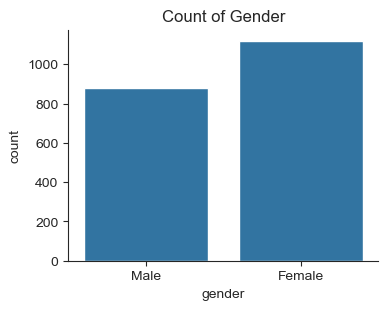

In [270]:
# Print value counts of gender
print(reviews3.gender.value_counts(normalize=True))

# Plot gender breakdown
plt.figure(figsize=(4,3))
sns.countplot(data=reviews3, x='gender')
plt.title('Count of Gender')
plt.show()

#### Education

education
graduate        0.450
PhD             0.230
postgraduate    0.200
diploma         0.095
Basic           0.025
Name: proportion, dtype: float64


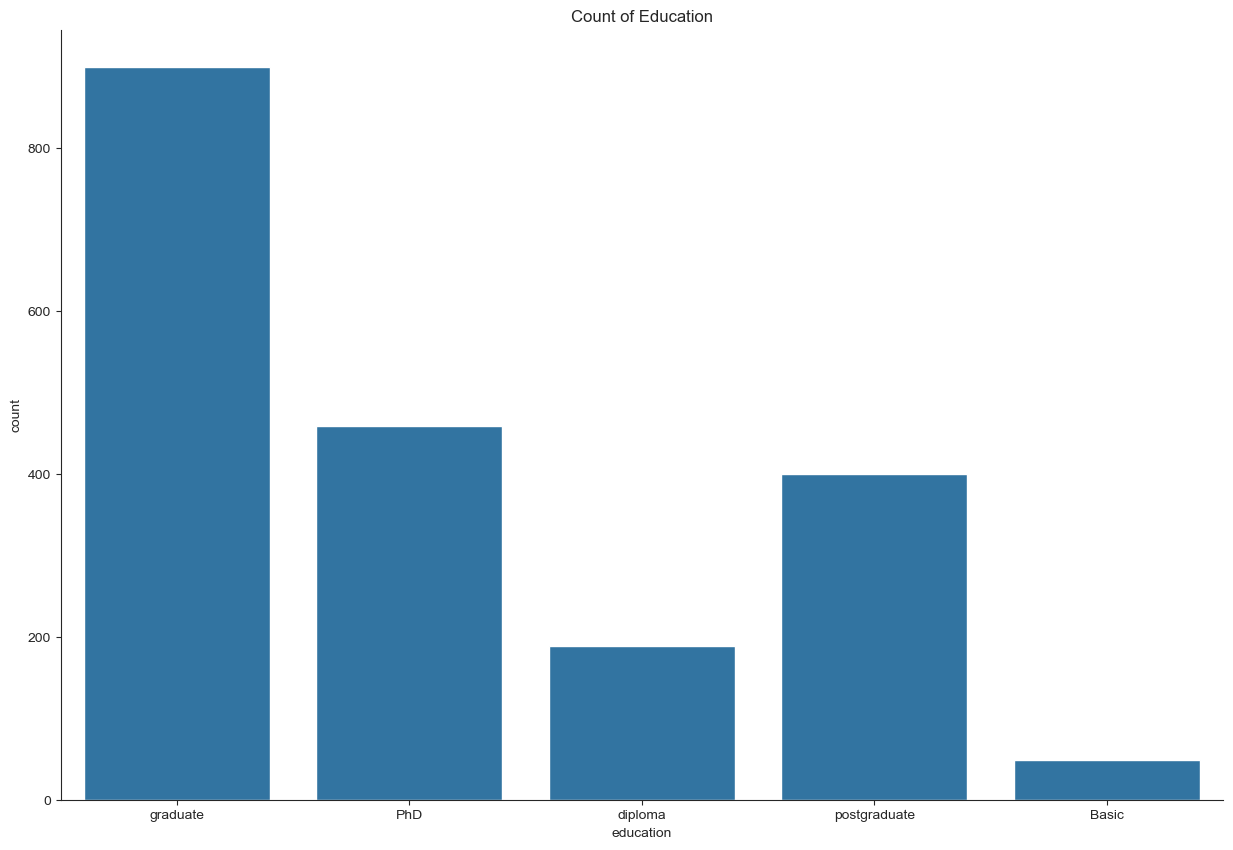

In [272]:
# Print value counts of education
print(reviews3.education.value_counts(normalize=True))

# Plot education breakdown
sns.countplot(data=reviews3, x='education')
plt.title('Count of Education')
plt.show()

In [273]:
# Collate education values

# Create lists for original and updated education values
orig_edu = ['graduate', 'PhD', 'diploma', 'postgraduate', 'Basic']
new_edu = ['university', 'advanced_degree', 'lower_edu', 'advanced_degree', 'lower_edu']

# Create a mapper
edu_mapper = dict(zip(orig_edu, new_edu))

# Map new values onto education col
reviews3['education'] = reviews3['education'].map(edu_mapper)

In [274]:
# Check result
reviews3['education'].unique()

array(['university', 'advanced_degree', 'lower_edu'], dtype=object)

education
university         0.45
advanced_degree    0.43
lower_edu          0.12
Name: proportion, dtype: float64


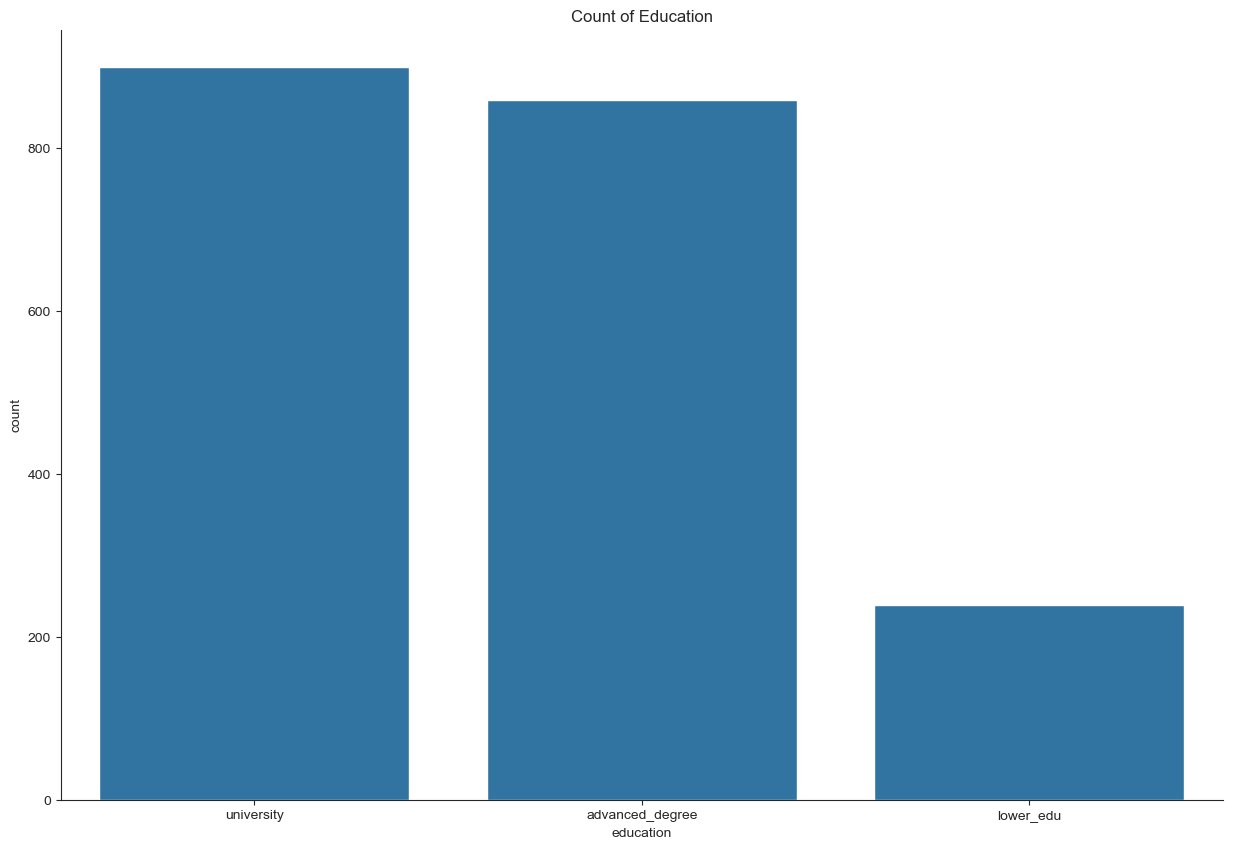

In [275]:
# Print value counts of education
print(reviews3.education.value_counts(normalize=True))

# Plot education breakdown
sns.countplot(data=reviews3, x='education')
plt.title('Count of Education')
plt.show()

### Save and reimport data

In [277]:
# Create a CSV file as output.
# reviews3.to_csv('reviews_clean.csv', index=False)

In [278]:
# Import new CSV file with Pandas.
turt = pd.read_csv('reviews_clean.csv')
turt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   income          2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB


## EDA and visualisations

### Boxplots

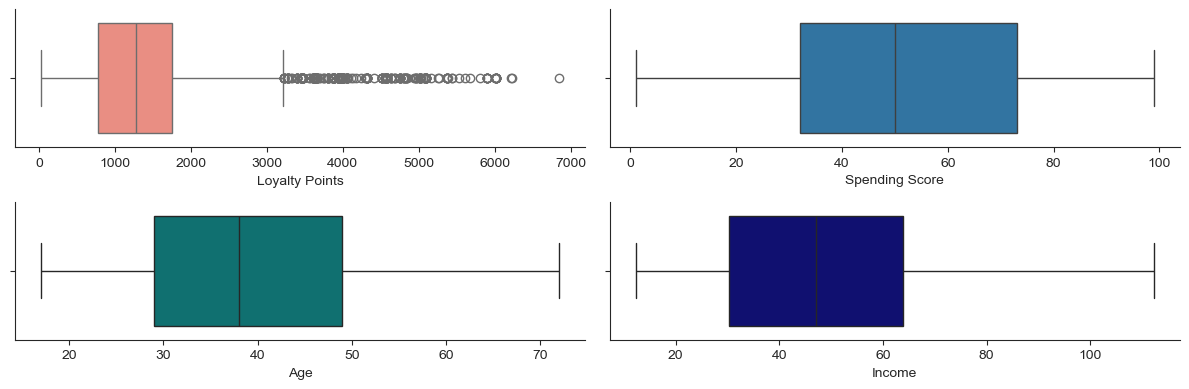

In [281]:
# View boxplots of continuous variables
plt.figure(figsize=(12,4))

plt.subplot(2,2,1)
sns.boxplot(data=turt, x='loyalty_points', color='salmon')
plt.xlabel('Loyalty Points')

plt.subplot(2,2,2)
sns.boxplot(data=turt, x='spending_score')
plt.xlabel('Spending Score')

plt.subplot(2,2,3)
sns.boxplot(data=turt, x='age', color='teal')
plt.xlabel('Age')

plt.subplot(2,2,4)
sns.boxplot(data=turt, x='income', color='navy')
plt.xlabel('Income')

plt.tight_layout()
plt.show()

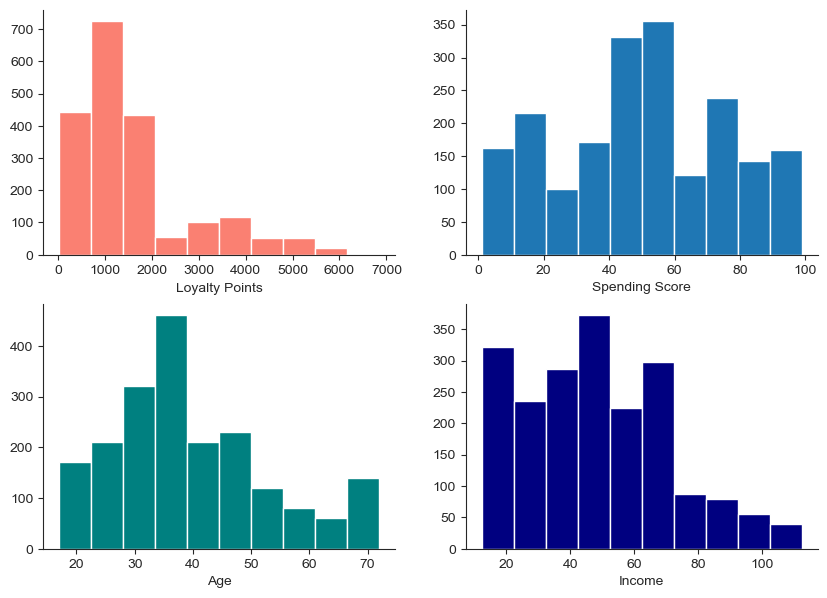

In [282]:
# View histograms of continuous variables
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
plt.hist(data=turt, x='loyalty_points', color='salmon')
plt.xlabel('Loyalty Points')

plt.subplot(2,2,2)
plt.hist(data=turt, x='spending_score')
plt.xlabel('Spending Score')

plt.subplot(2,2,3)
plt.hist(data=turt, x='age', color='teal')
plt.xlabel('Age')

plt.subplot(2,2,4)
plt.hist(data=turt, x='income', color='navy')
plt.xlabel('Income')

plt.show()

**Observation:** Loyalty points appears to have a high number of outliers, so this will be futher investigated below.

### Further outlier detection

In [285]:
# View summary stats of loyalty points column
turt['loyalty_points'].describe()

count    2000.000000
mean     1578.032000
std      1283.239705
min        25.000000
25%       772.000000
50%      1276.000000
75%      1751.250000
max      6847.000000
Name: loyalty_points, dtype: float64

In [286]:
# Calculate max outlier threshhold (Q3 + 1.5 * IQR) 
1751.250000 + 1.5 * (1751.250000 - 772.000000)

3220.125

In [287]:
# Determine number of outliers
outliers = turt[turt['loyalty_points'] >= 3220]

print('Number of outliers:', len(outliers))
print(f'Percentage of outliers: {len(outliers)/len(turt) * 100}%')

Number of outliers: 266
Percentage of outliers: 13.3%


**Observation:** 
- 13% of our target variable is outliers.
- Linear regression is sensitive to outliers, so this may affect our LR models.
- However, we have no reason to believe these outliers are not valid data, so will leave them in for now. 
- We may want to compare MLR performance with and without them.

### Correlations & relationships

In [290]:
# View correlations between continuous variables
turt.corr(numeric_only=True)

age    income  spending_score  loyalty_points   product
age             1.000000 -0.005708       -0.224334       -0.042445  0.003081
income         -0.005708  1.000000        0.005612        0.616065  0.305309
spending_score -0.224334  0.005612        1.000000        0.672310 -0.001649
loyalty_points -0.042445  0.616065        0.672310        1.000000  0.183600
product         0.003081  0.305309       -0.001649        0.183600  1.000000

**Observation:** Income and spending score show the strongest correlations with loyalty points.

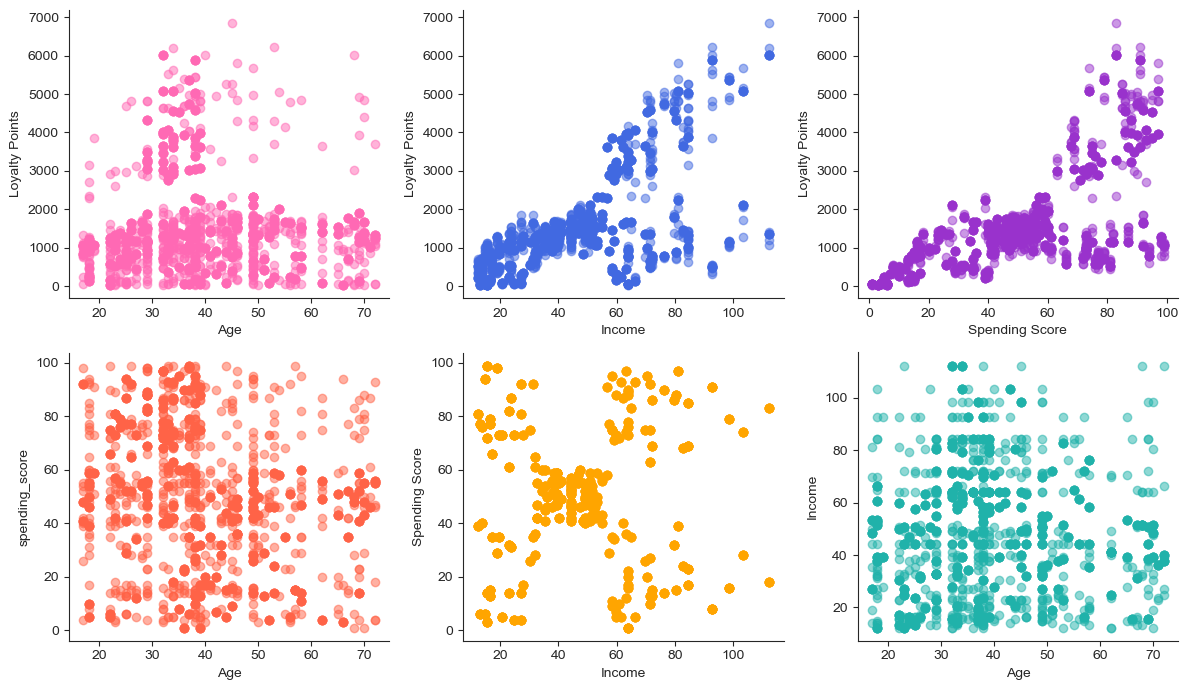

In [292]:
# View relationships with scatterplots
plt.figure(figsize=(12,7))

plt.subplot(2,3,1)
plt.ylabel('Loyalty Points')
plt.xlabel('Age')
plt.scatter(data=turt, y='loyalty_points', x='age', color='hotpink', alpha=0.5)

plt.subplot(2,3,2)
plt.ylabel('Loyalty Points')
plt.xlabel('Income')
plt.scatter(data=turt, y='loyalty_points', x='income', color='royalblue', alpha=0.5)

plt.subplot(2,3,3)
plt.ylabel('Loyalty Points')
plt.xlabel('Spending Score')
plt.scatter(data=turt, y='loyalty_points', x='spending_score', color='darkorchid', alpha=0.5)

plt.subplot(2,3,4)
plt.ylabel('spending_score')
plt.xlabel('Age')
plt.scatter(data=turt, y='spending_score', x='age', color='tomato', alpha=0.5)

plt.subplot(2,3,5)
plt.ylabel('Spending Score')
plt.xlabel('Income')
plt.scatter(data=turt, y='spending_score', x='income', color='orange', alpha=0.5)

plt.subplot(2,3,6)
plt.ylabel('Income')
plt.xlabel('Age')
plt.scatter(data=turt, y='income', x="age", color='lightseagreen', alpha=0.5)

plt.tight_layout()
plt.show()

In [293]:
# View difference in loyalty points by education
turt.groupby('education')[['loyalty_points']].mean() \
    .sort_values(by='loyalty_points', ascending=False).round()

loyalty_points
education                      
university               1666.0
lower_edu                1530.0
advanced_degree          1499.0

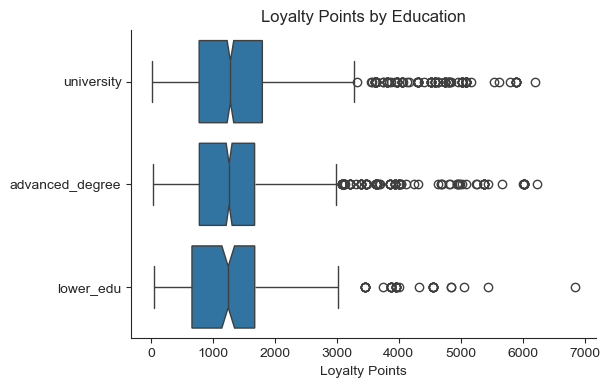

In [294]:
# Plot difference in loyalty points by education
plt.figure(figsize=(6,4))

sns.boxplot(data=turt, y='education', x='loyalty_points', notch=True)

plt.title('Loyalty Points by Education')
plt.xlabel('Loyalty Points')
plt.ylabel(None)

plt.show()

In [295]:
# View differnece in loyalty points by gender
turt.groupby('gender')[['loyalty_points']].mean().round()

loyalty_points
gender                
Female          1601.0
Male            1549.0

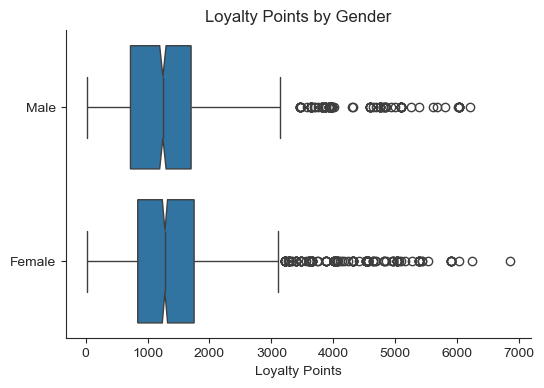

In [296]:
# Plot difference in loyalty points by gender
plt.figure(figsize=(6,4))

sns.boxplot(data=turt, y='gender', x='loyalty_points', notch=True)

plt.title('Loyalty Points by Gender')
plt.xlabel('Loyalty Points')
plt.ylabel(None)

plt.show()

### Stats

In [298]:
# Check for normal distribution
print('Income Shapiro-Wilk test:', stats.shapiro(turt['income']))
print('Spending Score Shapiro-Wilk test:', stats.shapiro(turt['spending_score']))
print('Loyalty Points Shapiro-Wilk test:', stats.shapiro(turt['loyalty_points']))
print('Age Shapiro-Wilk test:', stats.shapiro(turt['age']))

Income Shapiro-Wilk test: ShapiroResult(statistic=0.9676769125360404, pvalue=8.839614210894001e-21)
Spending Score Shapiro-Wilk test: ShapiroResult(statistic=0.968345181585895, pvalue=1.45323317110697e-20)
Loyalty Points Shapiro-Wilk test: ShapiroResult(statistic=0.8430727369718951, pvalue=1.2431393983403577e-40)
Age Shapiro-Wilk test: ShapiroResult(statistic=0.952421138780556, pvalue=5.3944884902236335e-25)


In [299]:
# Check for skewness
# Check for normal distribution
print('Income skew:', turt['income'].skew())
print('Spending Score skew:', turt['spending_score'].skew())
print('Loyalty Points skew:', turt['loyalty_points'].skew())
print('Age skew:', turt['age'].skew())

Income skew: 0.41315189821280984
Spending Score skew: -0.041648368459376015
Loyalty Points skew: 1.4647925003740154
Age skew: 0.6093007957146686


**Observations:** 
- None of the variables are normally distributed according to Shapiro-Wilk tests.
- Spending score and income are fairly symmetrical. Age is moderately right skewed.
- Loyalty points is highly right skewed.

## Observations on Overall Data Set

**Demographics:**
- Gender is relatively evenly split, with a slight female skew (56% female).
- Customers tend to be educated: 43% have advanced degrees and 45% a university degree.
- Age ranges from 17-72, with a mean age of 39. However, the customer base skews younger, with 62% under 40.

**Income and Loyalty Points:**
- Income ranges from £12K - £112K, with a mean income of £48K. Most customers make under £70K, with a longer tail of higher incomes.
- Loyalty points are heavily right-skewed; most have 2,000 or under, but there is a long tail of high loyalty points.
- Customers with a university degree have on average the highest loyalty points, while those with more advanced degrees have the lowest.
- Loyalty points do not meaningfully differ by gender (women have just slightly more on average).
- Looking at simple correlations and scatterplots, loyalty points are most highly positively correlated with spending score and income.

## Linear regression

### Single linear regression (SLR)

In [304]:
# Function to create a scatter plot with a regression line
def reg_plt(ind, dep='Loyalty Points', filename=None):
    # Set fig size
    plt.figure(figsize=(7,7))
    
    # Plot scatter and regression line
    plt.scatter(x, y, alpha=0.5, color='#56b779')
    plt.plot(x, y_pred, color='#4c4542')
    
    # Set axis limits
    plt.xlim(0)
    plt.ylim(0)
    
    # Remove axis lines on right and top
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Set titles and labels
    plt.ylabel(dep)
    plt.xlabel(ind)
    plt.title(f"{dep} x {ind}")

    plt.tight_layout()

    # Save file
    if filename:
        plt.savefig(filename, dpi=300)
        
    plt.show()

#### Spending vs loyalty

In [306]:
# Define variables
y = turt['loyalty_points']
x = turt['spending_score']

# Create model and print summary of metrics.
model = ols('y ~ x', data=turt).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     1648.
Date:                Thu, 22 May 2025   Prob (F-statistic):          2.92e-263
Time:                        18:26:17   Log-Likelihood:                -16550.
No. Observations:                2000   AIC:                         3.310e+04
Df Residuals:                    1998   BIC:                         3.312e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -75.0527     45.931     -1.634      0.102    -165.129      15.024
x             33.0617      0.814     40.595      0.000      31.464      34.659
==============================================================================
Omnibus:                      126.554   Durbin-Watson:                   1.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.528
Skew:                           0.422   Prob(JB):                     2.67e-57
Kurtosis:                       4.554   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [307]:
# Extract the estimated parameters.
print('Correlation coefficient:')
print(model.params)
print()

# Extract the standard errors.
print('Standard Error:')
print(model.bse)
print()

# Extract the predicted values.
model.predict()

Correlation coefficient:
Intercept   -75.052663
x            33.061693
dtype: float64

Standard Error:
Intercept    45.930554
x             0.814419
dtype: float64



array([1214.35337415, 2602.94449102,  123.31749662, ..., 2933.56142361,
        453.93442921,  189.44088314])

In [308]:
# Set the the X coefficient and the constant to generate the regression table.
y_pred = model.params['Intercept'] +  model.params['x'] *turt['spending_score']

# View the output.
y_pred

0       1214.353374
1       2602.944491
2        123.317497
3       2470.697718
4       1247.415067
           ...     
1995    2206.204172
1996     189.440883
1997    2933.561424
1998     453.934429
1999     189.440883
Name: spending_score, Length: 2000, dtype: float64

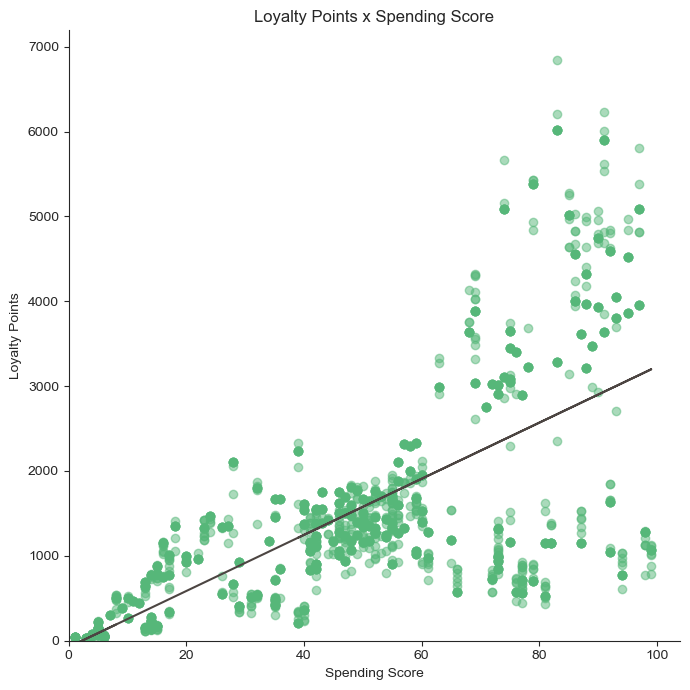

In [309]:
# Plot graph with regression line
# See reg_plot func at beginning of section
reg_plt('Spending Score')

#### Income vs loyalty

In [311]:
# Define variables.
y = turt['loyalty_points']
x = turt['income']

# Create model and print summary of metrics.
model = ols('y ~ x', data=turt).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     1222.
Date:                Thu, 22 May 2025   Prob (F-statistic):          2.43e-209
Time:                        18:26:17   Log-Likelihood:                -16674.
No. Observations:                2000   AIC:                         3.335e+04
Df Residuals:                    1998   BIC:                         3.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -65.6865     52.171     -1.259      0.208    -168.001      36.628
x             34.1878      0.978     34.960      0.000      32.270      36.106
==============================================================================
Omnibus:                       21.285   Durbin-Watson:                   3.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.715
Skew:                           0.089   Prob(JB):                     1.30e-07
Kurtosis:                       3.590   Cond. No.                         123.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [312]:
# Extract the estimated parameters.
print('Correlation coefficient:')
print(model.params)
print()

# Extract the standard errors.
print("Standard Error:")
print(model.bse)
print()

# Extract the predicted values.
model.predict()

Correlation coefficient:
Intercept   -65.686513
x            34.187825
dtype: float64

Standard Error:
Intercept    52.170717
x             0.977925
dtype: float64



array([ 354.82374068,  354.82374068,  382.85775758, ..., 3102.15739671,
       3298.39551499, 3102.15739671])

In [313]:
# Set the the X coefficient and the constant to generate the regression table.
y_pred = model.params['Intercept'] +  model.params['x'] * turt['income']

# View the output.
y_pred

0        354.823741
1        354.823741
2        382.857758
3        382.857758
4        410.891774
           ...     
1995    2821.817228
1996    3102.157397
1997    3102.157397
1998    3298.395515
1999    3102.157397
Name: income, Length: 2000, dtype: float64

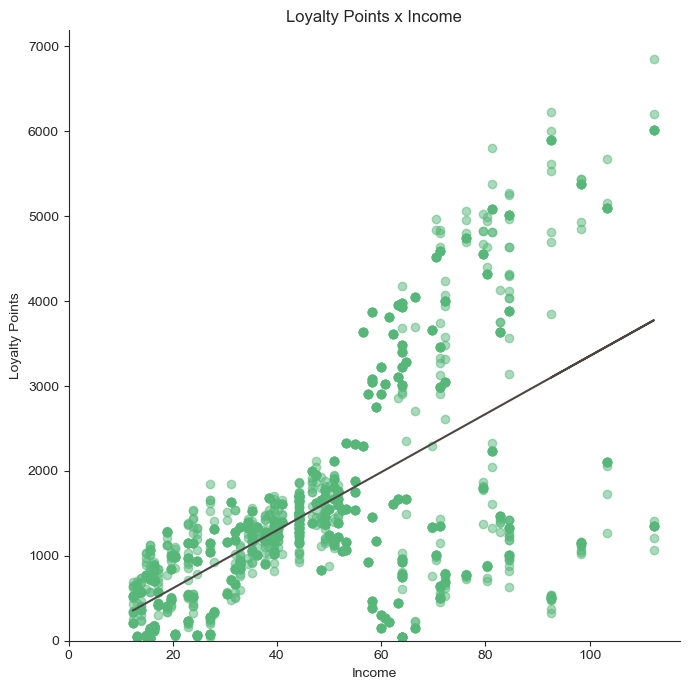

In [314]:
# Plot graph with regression line.
reg_plt('Income')

#### Age vs loyalty

In [316]:
# Define variables
y = turt['loyalty_points']
x = turt['age']

# Create model and print summary of metrics.
model = ols('y ~ x', data=turt).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.606
Date:                Thu, 22 May 2025   Prob (F-statistic):             0.0577
Time:                        18:26:18   Log-Likelihood:                -17150.
No. Observations:                2000   AIC:                         3.430e+04
Df Residuals:                    1998   BIC:                         3.431e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1736.5177     88.249     19.678      0.000    1563.449    1909.587
x             -4.0128      2.113     -1.899      0.058      -8.157       0.131
==============================================================================
Omnibus:                      481.477   Durbin-Watson:                   2.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              937.734
Skew:                           1.449   Prob(JB):                    2.36e-204
Kurtosis:                       4.688   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [317]:
# Extract the estimated parameters.
print('Correlation coefficient:')
print(model.params)
print()

# Extract the standard errors.
print('Standard Error:')
print(model.bse)
print()

# Extract the predicted values.
model.predict()

Correlation coefficient:
Intercept    1736.517739
x              -4.012805
dtype: float64

Standard Error:
Intercept    88.248731
x             2.113177
dtype: float64



array([1664.2872467 , 1644.22322095, 1648.2360261 , ..., 1600.0823643 ,
       1600.0823643 , 1608.1079746 ])

In [318]:
# Set the the X coefficient and the constant to generate the regression table.
y_pred = model.params['Intercept'] +  model.params['x'] * turt['age']

# View the output.
y_pred

0       1664.287247
1       1644.223221
2       1648.236026
3       1636.197611
4       1604.095169
           ...     
1995    1588.043949
1996    1563.967118
1997    1600.082364
1998    1600.082364
1999    1608.107975
Name: age, Length: 2000, dtype: float64

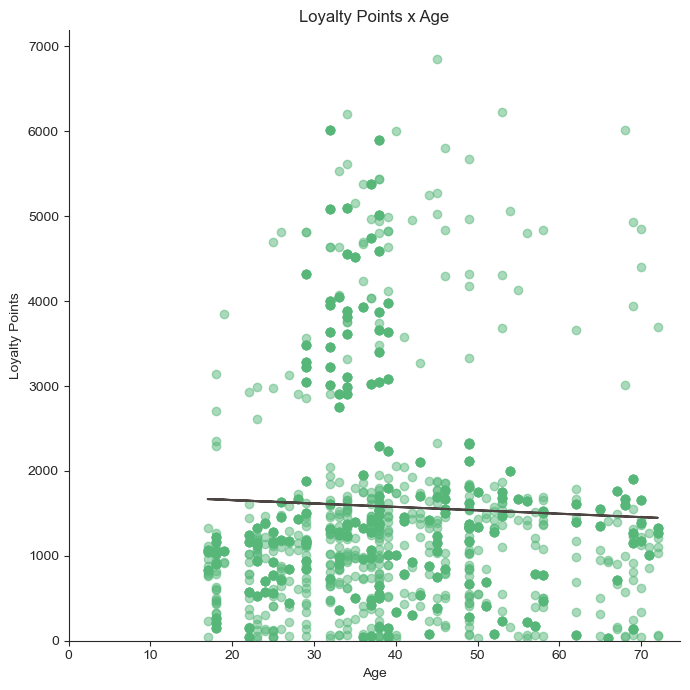

In [319]:
# Plot graph with regression line.
reg_plt('Age')

**Observation:** Using SLR, spending score and income are better predictors of loyalty points than age.

### Multiple linear regression (MLR)

#### Check for multicollinearity

In [323]:
# Create new DataFrame with the X-variables only
turtvif = pd.DataFrame(turt, columns=['spending_score', 'age', 'income'])

# Create an empty DataFrame
vif = pd.DataFrame()

# Determine VIF for each of the varaibles 
vif['Variable'] = turtvif.columns
vif['VIF'] = [variance_inflation_factor(turtvif.values, i) for i in range(turtvif.shape[1])]
vif.round(1)

Variable  VIF
0  spending_score  3.3
1             age  4.3
2          income  4.2

**Observation:** VIF for each variable is greater than 1 but less than 5, indicating moderate correlation. However, VIF is not high enough to discount any variables.

#### Fit and train model

In [326]:
# Create variables
X = turt[['income', 'spending_score', 'age']]
y = turt['loyalty_points']

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add intercept/constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Create model and print summary of metrics
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         loyalty_points   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     2513.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        18:26:18   Log-Likelihood:                -10711.
No. Observations:                1400   AIC:                         2.143e+04
Df Residuals:                    1396   BIC:                         2.145e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2185.5298     61.684    -35.431      0.000   -2306.534   -2064.526
income            34.4787      0.591     58.304      0.000      33.319      35.639
spending_score    33.7217      0.538     62.629      0.000      32.666      34.778
age               10.7664      1.027     10.485      0.000       8.752      12.781
==============================================================================
Omnibus:                       10.911   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.554
Skew:                           0.172   Prob(JB):                      0.00310
Kurtosis:                       3.283   Cond. No.                         375.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Evaluate MLR model

#### Visualise predicted values vs. test values

In [329]:
# Predict the response for test dataset
y_pred = model.predict(X_test)
y_pred.shape

(600,)

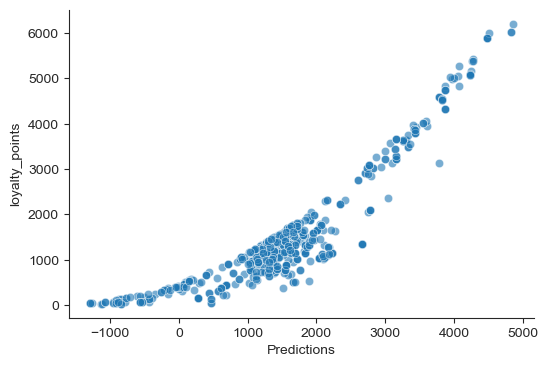

In [330]:
# Plot pred vs. test values
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.6)
plt.xlabel('Predictions')
plt.show()

#### Check for homoscedasticity

In [332]:
# Run the Breusch-Pagan test function on the model residuals and x-variables.
test = sms.het_breuschpagan(model.resid, model.model.exog)

# Print the results.
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
print(dict(zip(terms, test)))

{'LM stat': 32.07984528506573, 'LM Test p-value': 5.03455889174546e-07, 'F-stat': 10.912787042331491, 'F-test p-value': 4.3690776756376296e-07}


**Observation:** Heretoscedasticity is present, i.e. size of errors varies. This suggests the model may be unstable.

#### Check normality of residuals

In [335]:
# Create a variable for residuals
residuals = y_test - y_pred

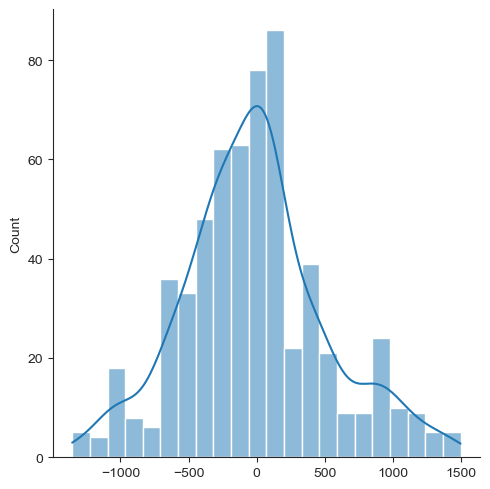

In [336]:
# Plot residuals distribution with a histogram
sns.displot(residuals, kde=True, height=5)
plt.show()

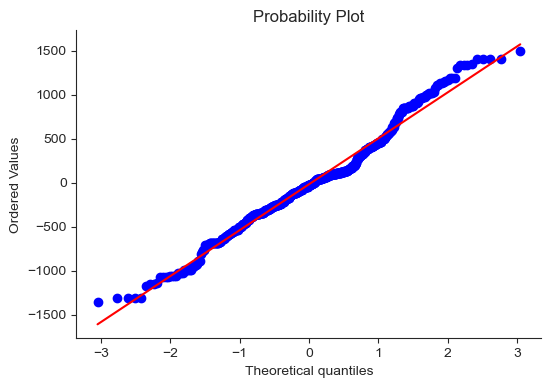

In [337]:
# Plot residuals with a Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist='norm', plot=pylab)
plt.show()

In [338]:
# Run Shapiro-Wilk test
stats.shapiro(residuals)

ShapiroResult(statistic=0.9826932715405785, pvalue=1.5206433794036807e-06)

**Observations:** 
- The Q-Q plot shows an S shape, indicating residuals are skewed.
- The Shapiro-Wilk test also indicates non-normality of residuals.

In [340]:
# Function to print linear regression metrics

def lr_metrics(model, title):
    # Print metrics for the model
    print(title, ':')
    print()

    # Determine and print r-squared
    train_score = model.rsquared
    test_score = r2_score(y_test, y_pred)

    print(f"Train R-squared score: {train_score:.2f}")
    print(f"Test R-squared score: {test_score:.2f}")
    print()

    # Determine and print errors
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"RMSE-MAE percentage difference = {((rmse - mae) / mae * 100):.0f}%")

In [341]:
# Print metrics for the model
lr_metrics(model, 'MLR')

MLR :

Train R-squared score: 0.84
Test R-squared score: 0.83

Mean Absolute Error: 398.03
Mean Squared Error: 275278.88
Root Mean Squared Error: 524.67
RMSE-MAE percentage difference = 32%


### Testing the model without outliers
Because linear regression is sensitive to outliers, we will test the model again after removing them.

In [343]:
# Create a new dataframe removing outliers
no_outliers = turt[turt['loyalty_points'] <= 3220]
no_outliers.shape

(1734, 9)

#### Fit and test model

In [345]:
# Create variables
X = no_outliers[['income', 'spending_score', 'age']]
y = no_outliers['loyalty_points']

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add intercept/constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Create model and print summary of metrics
model2 = sm.OLS(y_train, X_train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         loyalty_points   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     1104.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        18:26:20   Log-Likelihood:                -8856.7
No. Observations:                1213   AIC:                         1.772e+04
Df Residuals:                    1209   BIC:                         1.774e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1214.5936     49.758    -24.410      0.000   -1312.214   -1116.973
income            21.8666      0.520     42.017      0.000      20.846      22.888
spending_score    23.6123      0.467     50.581      0.000      22.696      24.528
age                9.0143      0.731     12.329      0.000       7.580      10.449
==============================================================================
Omnibus:                        0.310   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.857   Jarque-Bera (JB):                0.282
Skew:                           0.037   Prob(JB):                        0.868
Kurtosis:                       3.009   Cond. No.                         366.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [346]:
# Predict the response for test dataset
y_pred = model2.predict(X_test)
y_pred.shape

(521,)

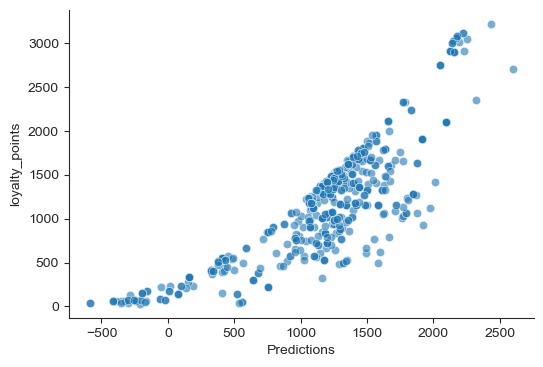

In [347]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.6)
plt.xlabel('Predictions')
plt.show()

In [348]:
# Create a variable for residuals
residuals = y_test - y_pred

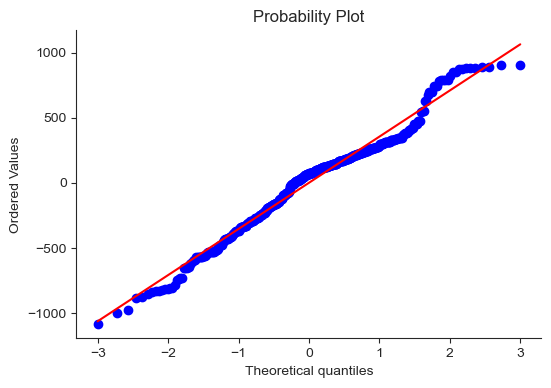

In [349]:
# Plot residuals with a Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist='norm', plot=pylab)
plt.show()

In [350]:
# Run the Breusch-Pagan test function on the model residuals and x-variables.
test = sms.het_breuschpagan(model2.resid, model2.model.exog)

# Print the results.
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
print(dict(zip(terms, test)))

{'LM stat': 190.65819160690214, 'LM Test p-value': 4.3997473421464676e-41, 'F-stat': 75.1561274192142, 'F-test p-value': 1.4142674645391437e-44}


In [351]:
# Run Shapiro-Wilk test
stats.shapiro(residuals)

ShapiroResult(statistic=0.9772060594574836, pvalue=2.941403536736863e-07)

In [352]:
# Print metrics for the model
lr_metrics(model2, 'MLR - OUTLIERS REMOVED')

MLR - OUTLIERS REMOVED :

Train R-squared score: 0.73
Test R-squared score: 0.71

Mean Absolute Error: 280.28
Mean Squared Error: 126821.42
Root Mean Squared Error: 356.12
RMSE-MAE percentage difference = 27%


**Observation:** Adjusted R-squared after removal of outliers is lower (i.e. the model is weaker) but residuals are still problematic. This suggests that MLR is not the best model for this data (i.e. the problem is not the outliers).

## Observations on regression models overall

- MLR model will be prioritised over the SLRs because it accounts for interrelationships between all variables.
- MLR shows that 84% of variability (with outliers) or 73% (outliers removed) can be explained by income, age and spending score.
- All three variables are statistically significant. Spending score and income have the strongest (positive) relationships with loyalty points.
- The moderate level of multicollinearity between the explanatory variables could explain the discrepancy in age coefficient between SLR vs. MLR.
- Evaluation tests suggests the data may not have a linear relationship and thus linear regression is not the ideal model:
  - Scatterplot of actual vs. test values shows a slight curve.
  - S-shaped curve of residuals in Q-Q plot.
  - Shapiro-Wilk test returns a p-value under the 0.05 threshhold.
  - Heteroscedasticity is present.
- **Business implication:** Income seems to be the most useful external factor for predicting customer behavior, since age doesn’t have much impact on loyalty and the spending score is an internal metric. But residuals testing suggests this model is not ideal, and other models should be tested before accepting this conclusion.

# 

# Week 2: Decision trees

## Library imports

In [358]:
# Import all the necessary packages
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import statsmodels.api as sm
import shap
import warnings
import matplotlib.pyplot as plt

# Settings for the notebook.
# warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 10]

## Load and prepare data

In [360]:
# Create a new DataFrame.
turt2 = pd.read_csv('reviews_clean.csv')
# Drop unneeded cols
turt2 = turt2.drop(columns=['product', 'review', 'summary'])

print(turt2.info())
turt2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   income          2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 93.9+ KB
None


gender  age  income  spending_score  loyalty_points   education
0    Male   18   12.30              39             210  university
1    Male   23   12.30              81             524  university
2  Female   22   13.12               6              40  university
3  Female   25   13.12              77             562  university
4  Female   33   13.94              40             366  university

In [361]:
# Create dummy variables
cat_vars = ['gender', 'education']

turt_dt = pd.get_dummies(turt2, columns=cat_vars, drop_first=True, dtype=int)

# Check the data
turt_dt.head()

age  income  spending_score  loyalty_points  gender_Male  \
0   18   12.30              39             210            1   
1   23   12.30              81             524            1   
2   22   13.12               6              40            0   
3   25   13.12              77             562            0   
4   33   13.94              40             366            0   

   education_lower_edu  education_university  
0                    0                     1  
1                    0                     1  
2                    0                     1  
3                    0                     1  
4                    0                     1

In [362]:
# Re-check for nulls
turt_dt.isna().sum()

age                     0
income                  0
spending_score          0
loyalty_points          0
gender_Male             0
education_lower_edu     0
education_university    0
dtype: int64

## Decision tree regressor - unpruned

In [364]:
# Specify variables
X = turt_dt.drop(columns='loyalty_points')
y = turt_dt['loyalty_points']

# Review X and Y.
print(X.columns)
print(X.shape, y.shape)

Index(['age', 'income', 'spending_score', 'gender_Male', 'education_lower_edu',
       'education_university'],
      dtype='object')
(2000, 6) (2000,)


In [365]:
# Create test and train data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check sizes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 6), (600, 6), (1400,), (600,))

In [366]:
# Create a decision tree regressor
dtr = DecisionTreeRegressor(random_state=42)

# Fit the model
dtr = dtr.fit(X_train, y_train)

In [367]:
# Function to print metrics for decision trees and random forests

def dtr_metrics(model, title):
    print(title, ':')
    print()

    # Determine and print r-squared
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Train R-squared score: {train_score:.2f}")
    print(f"Test R-squared score: {test_score:.2f}")
    print()

    # Make predictions inside the function to ensure consistency
    y_pred = model.predict(X_test)

    # Determine and print errors
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"RMSE-MAE percentage difference = {((rmse - mae) / mae * 100):.0f}%")

In [368]:
# Evaluate the model
dtr_metrics(dtr, 'UNPRUNED TREE')
print()
print('Depth =',dtr.get_depth())
print('Leaves =',dtr.get_n_leaves())

UNPRUNED TREE :

Train R-squared score: 1.00
Test R-squared score: 1.00

Mean Absolute Error: 29.41
Mean Squared Error: 7274.19
Root Mean Squared Error: 85.29
RMSE-MAE percentage difference = 190%

Depth = 22
Leaves = 558


**Observation:** Perfect R-squared and low MAE indicates model is overfitted and should be pruned.

## Prune tree

In [371]:
# Find optimal max_depth
max_depth_range = list(range(1, 11))

# List to store avg RMSE for each value of max_depth
accuracy = []

for depth in max_depth_range:
    dtr = DecisionTreeRegressor(max_depth = depth, random_state=42)
    dtr.fit(X_train, y_train)
    score = dtr.score(X_test, y_test)
    accuracy.append(score)

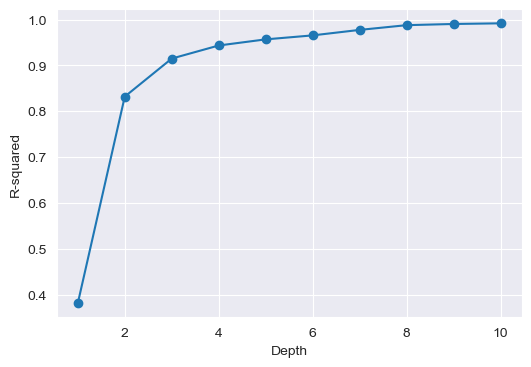

In [372]:
# Visualise max depth
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4))
plt.plot(max_depth_range, accuracy, marker='o')
plt.xlabel('Depth')
plt.ylabel('R-squared')
plt.show()

In [373]:
# Prune the model.
dtr2 = DecisionTreeRegressor(criterion='squared_error', 
                             max_depth=4,
                             min_samples_leaf=10,
                             random_state=42)

# Fit the model
dtr2 = dtr2.fit(X_train, y_train)

In [374]:
# Evaluate the model
dtr_metrics(dtr2, 'PRUNED TREE')
print()
print('Depth =',dtr.get_depth())
print('Leaves =',dtr.get_n_leaves())

PRUNED TREE :

Train R-squared score: 0.95
Test R-squared score: 0.94

Mean Absolute Error: 217.01
Mean Squared Error: 95772.82
Root Mean Squared Error: 309.47
RMSE-MAE percentage difference = 43%

Depth = 10
Leaves = 321


In [375]:
# Assess feature importance
dtr2_input = dtr2
importances2 = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(dtr2_input.feature_importances_,3)})
importances2['Importance'] = importances2['Importance']*100

# Sort values
importances2 = importances2.sort_values('Importance', ascending=False)

importances2

Feature  Importance
1                income        50.6
2        spending_score        49.4
0                   age         0.0
3           gender_Male         0.0
4   education_lower_edu         0.0
5  education_university         0.0

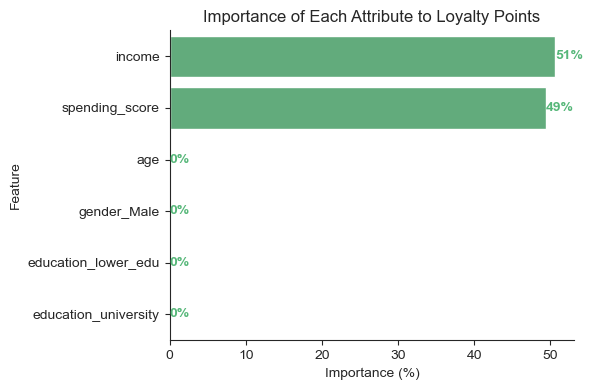

In [376]:
sns.set_style('ticks', {
       'axes.spines.top': False,     
       'axes.spines.right': False})
plt.figure(figsize=(6,4))

ax = sns.barplot(data=importances2, x='Importance', y='Feature', color='#56b779')

# Set data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f%%', color='#56b779', weight='bold')

ax.set(xlabel = 'Importance (%)',
      title = 'Importance of Each Attribute to Loyalty Points')

plt.tight_layout()
plt.savefig('importances.png')
plt.show()

## Random forest

In [378]:
# Create a RandomForestRegressor model
forest = RandomForestRegressor(n_estimators=200, criterion='squared_error', 
                                min_samples_split=2, min_samples_leaf=2,
                                max_features='sqrt', bootstrap=True,
                                n_jobs=1, random_state=42)

# Fit the model on the training data
forest.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=200,
                      n_jobs=1, random_state=42)

In [379]:
# Evaluate the model.
dtr_metrics(forest, 'RANDOM FOREST')

RANDOM FOREST :

Train R-squared score: 1.00
Test R-squared score: 0.99

Mean Absolute Error: 64.88
Mean Squared Error: 19046.25
Root Mean Squared Error: 138.01
RMSE-MAE percentage difference = 113%


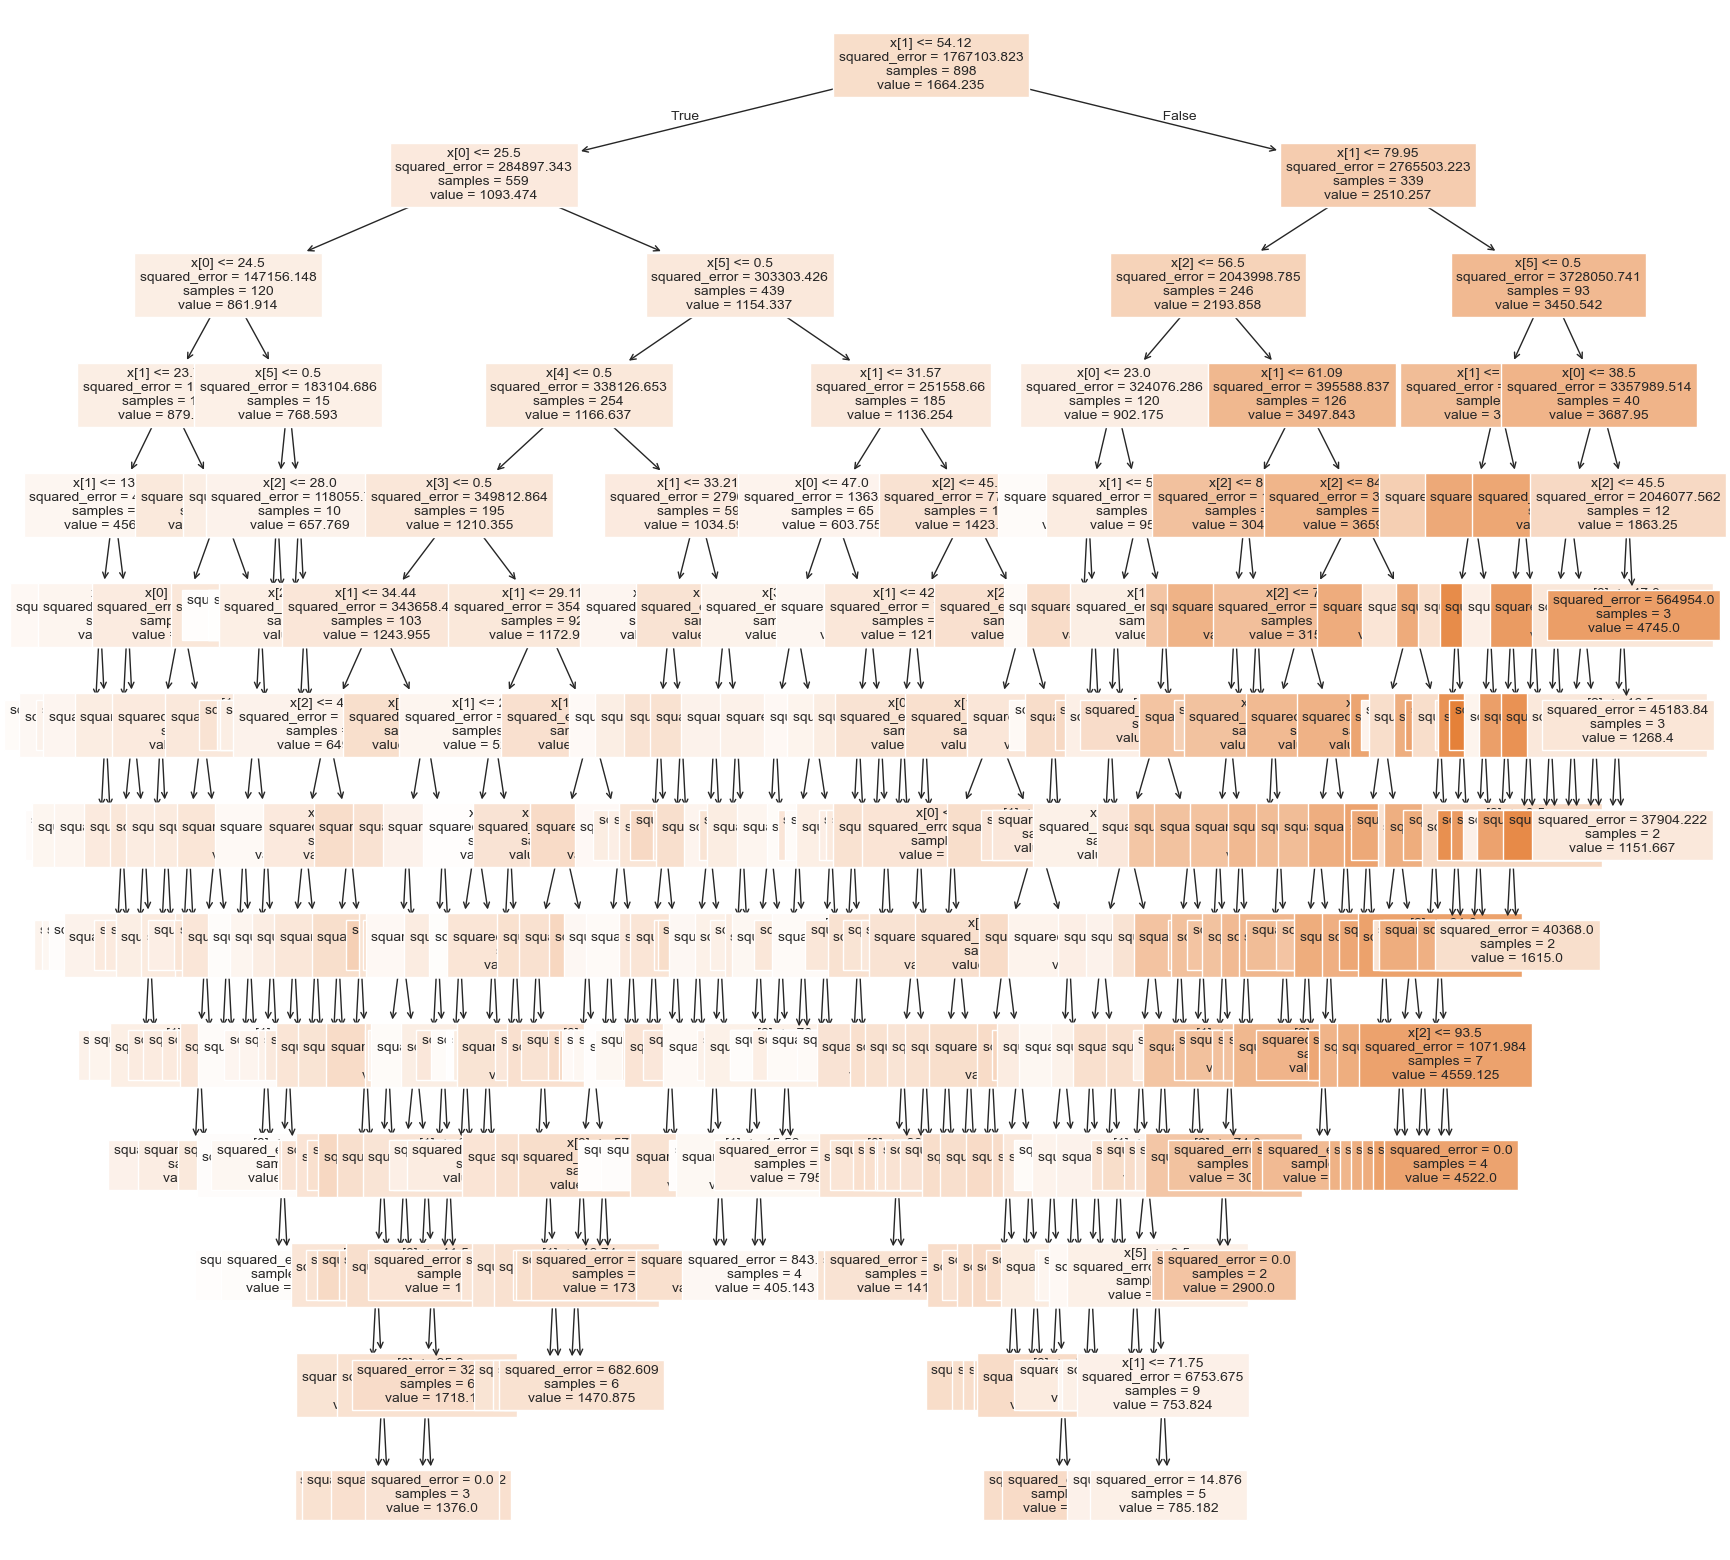

In [380]:
# Plot model
plt.figure(figsize=(20, 20))

tree.plot_tree(forest.estimators_[0],
               filled=True,
               fontsize=10)

plt.savefig('forest.png', dpi=300)
plt.show()

In [381]:
# Assess feature importance
forest_input = forest
forest_importance = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(forest_input.feature_importances_,3)})
forest_importance['Importance'] = forest_importance['Importance']*100

# Sort values
forest_importance = forest_importance.sort_values('Importance', ascending=False)

mapper = {'spending_score' : 'Spending Score',
          'income' : 'Income', 
          'age' : 'Age', 
          'gender_Male' : 'Gender (male)',
          'education_university' : 'Education (university)', 
          'education_lower_edu' : 'Education (lower education)'}

forest_importance['Feature'] = forest_importance['Feature'].map(mapper)

forest_importance

Feature  Importance
2               Spending Score        50.6
1                       Income        38.3
0                          Age         9.6
3                Gender (male)         0.6
5       Education (university)         0.6
4  Education (lower education)         0.3

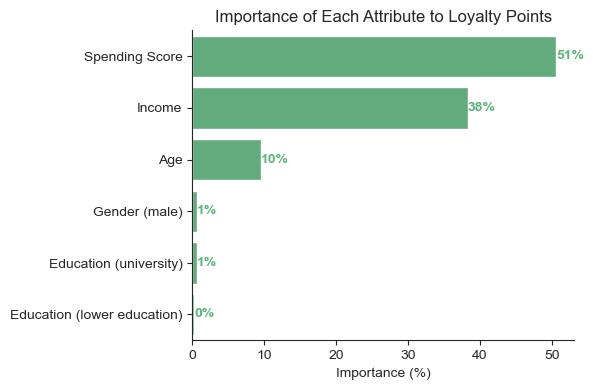

In [382]:
sns.set_style('ticks', {
       'axes.spines.top': False,     # Removes top axis line
       'axes.spines.right': False})
plt.figure(figsize=(6,4))

ax = sns.barplot(data=forest_importance, x='Importance', y='Feature', color='#56b779')

# Set data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f%%', color='#56b779', weight='bold')

ax.set(xlabel = 'Importance (%)',
       ylabel = '',
      title = 'Importance of Each Attribute to Loyalty Points')

plt.tight_layout()
plt.savefig('importances.png', dpi=300)
plt.show()

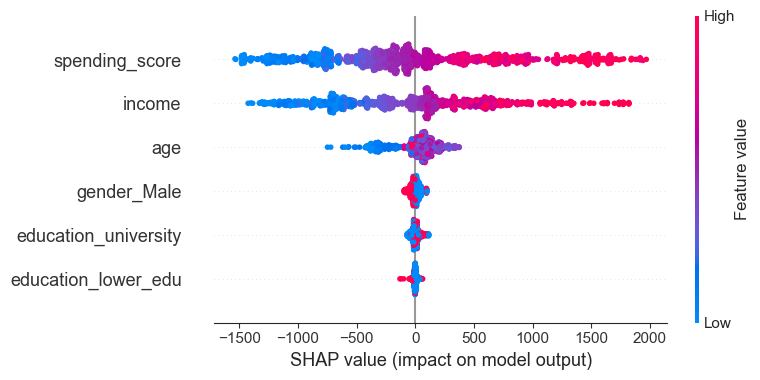

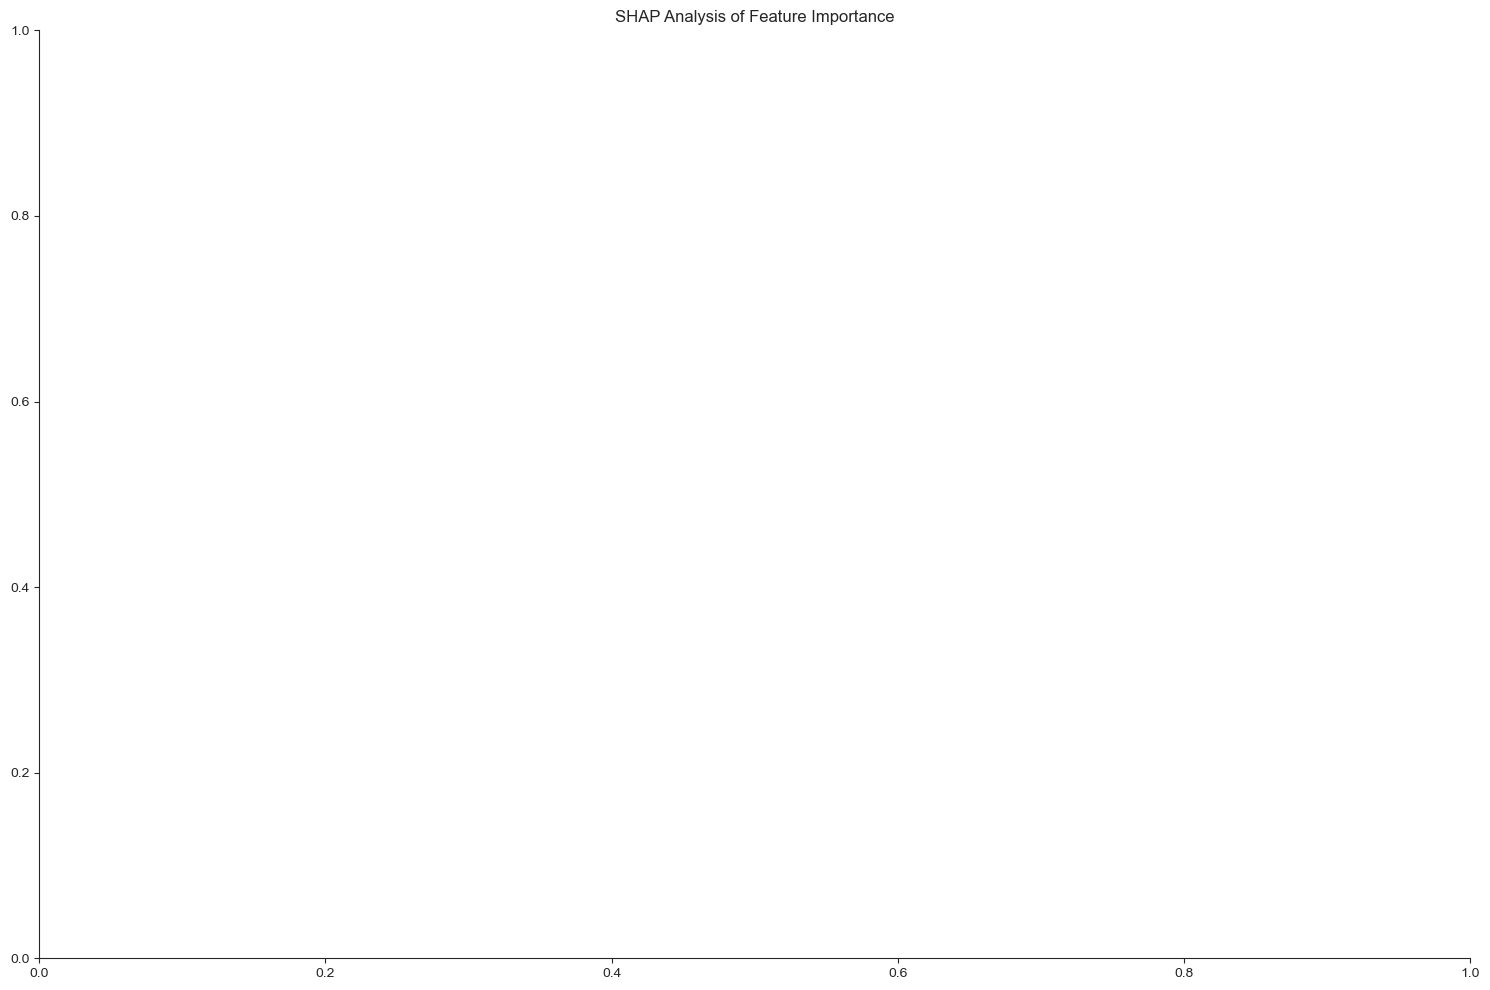

In [383]:
# Create a SHAP explainer
explainer2 = shap.TreeExplainer(forest)
shap_values = explainer2.shap_values(X_train)

# Plot the SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train)

# Title
plt.title('SHAP Analysis of Feature Importance')

plt.tight_layout()
plt.savefig('forest_shap.png', dpi=300)
plt.show()

**Observation:** For simplicity and ease of interpretation, feature-importance bar chart will be used to show stakeholders what attributes matter. But SHAP visualisation is useful to confirm how age factors in to loyalty points.

## Observations on decision-tree and random-forest models

- Initial decision tree has a perfect R-squared, indicating overfitting. The model should be pruned.
- Pruning methods included changing the criterion between absolute and mean error (in attempts to minimise RMSE/MAE difference), altering max_depth (based on an assessment of optimal max_depth range), and changing min_sample_leaves.
- The following combination was chosen due to high r-squared and reduced RMSE-MAE difference: criterion='squared_error', max_depth=4, min_samples_leaf=10
- The pruned model achieves 94% test-data R-squared. It also has higher errors but is less sensitive to outliers so should generalise better to new data.
- A random forest model outperforms decision trees, with a near-perfect R-squared and lower MAE. Since random forests are more accurate and less prone to overfitting, this high R-squared is less of a concern than it would be with a decision tree.
- Random forest should be used as the final model. Becuase this data set is not particularly large, computational power is not an issue.
- All models all outperform linear regression. This corroborates our Week-1 assumption that variable relationship is not fully linear.
- Feature analysis supports findings of the MLR, indicating that spending score and income are the most impactful variables.

# 

# Week 3 *k*-means clustering

## Library imports

In [389]:
# Import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

## Load and prep data

In [391]:
# Load the CSV file(s).
turt4 = pd.read_csv('reviews_clean.csv')

# View DataFrame.
print(turt4.info())
turt4.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   income          2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB
None


gender  age  income  spending_score  loyalty_points   education  product  \
0    Male   18   12.30              39             210  university      453   
1    Male   23   12.30              81             524  university      466   
2  Female   22   13.12               6              40  university      254   
3  Female   25   13.12              77             562  university      263   
4  Female   33   13.94              40             366  university      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap

In [392]:
# Drop unnecessary columns.
turt_k = turt4[['income', 'spending_score']]

# View DataFrame.
print(turt_k.info())
turt_k.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   income          2000 non-null   float64
 1   spending_score  2000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


income  spending_score
0   12.30              39
1   12.30              81
2   13.12               6
3   13.12              77
4   13.94              40

## Visualise data

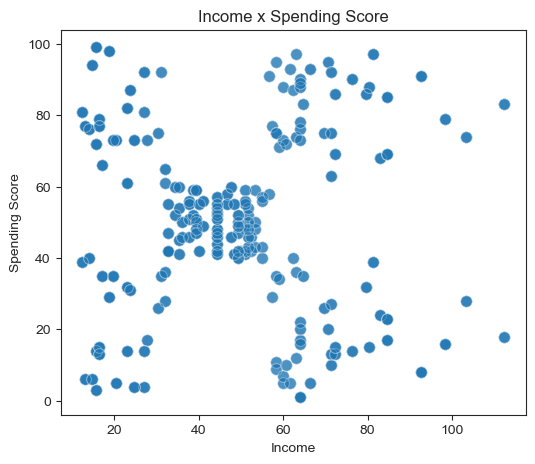

In [394]:
# Create a scatterplot
plt.figure(figsize=(6,5))
sns.set_style('ticks')
sns.scatterplot(data=turt_k,
                x='income',
                y='spending_score', s=70, alpha=0.2)

plt.title('Income x Spending Score')
plt.xlabel('Income')
plt.ylabel('Spending Score')

plt.show()

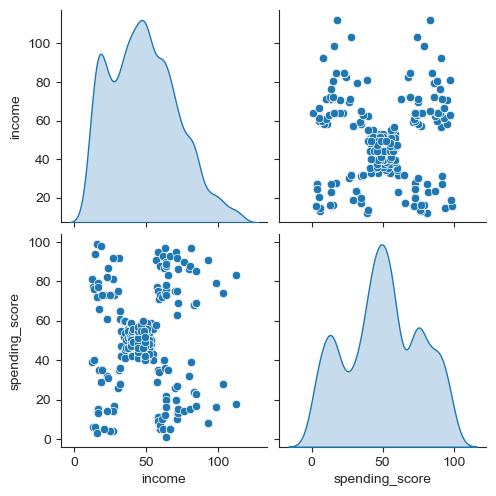

In [395]:
# Create a pairplot
sns.pairplot(data=turt_k, diag_kind='kde')
plt.show()

## Determine *k*

#### Elbow method

In [398]:
# Determine the number of clusters: Elbow method.
ss = []  

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(turt_k)
    ss.append(kmeans.inertia_)

ss

[2430088.5950327986,
 1527364.8762452041,
 1006659.3689455045,
 633387.5677305027,
 348507.3568197286,
 302096.8179823201,
 256038.65918514162,
 222593.04085530154,
 182630.76832996687,
 163244.3454056987]

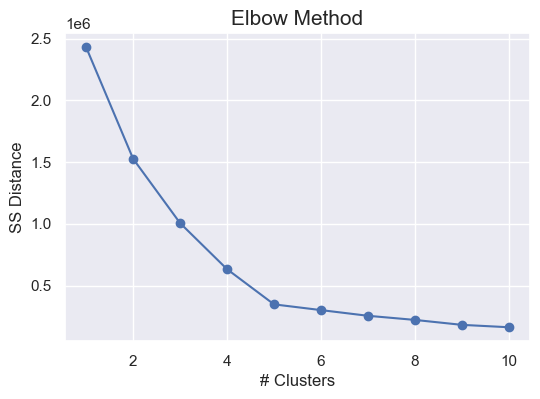

In [399]:
# Plot result
sns.set(style='darkgrid')
plt.figure(figsize=(6,4))
plt.plot(range(1, 11),
         ss,
         marker='o')

# Insert labels and title.
plt.title('Elbow Method', fontsize=15)
plt.xlabel('# Clusters')
plt.ylabel('SS Distance')

plt.show()

#### Silhouette method

In [401]:
# Determine the number of clusters: Silhouette method.
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans_s = KMeans(n_clusters=k).fit(turt_k)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(turt_k, labels, metric='euclidean'))

sil

[0.3203710299022974,
 0.42806848465628544,
 0.4001021900815371,
 0.5834953298348279,
 0.5574405549263802,
 0.4598816795069448,
 0.5305514617062652,
 0.464972992579786,
 0.4598329831327842]

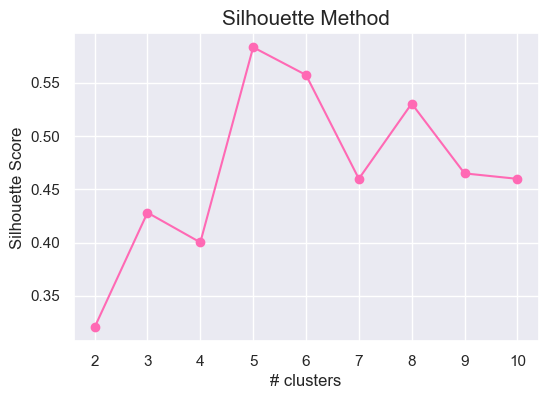

In [402]:
# Plot silhouette method
plt.figure(figsize=(6,4))
plt.plot(range(2, kmax+1),
         sil,
         marker='o',
         color='hotpink')

# Insert labels and title.
plt.title('Silhouette Method', fontsize=15)
plt.xlabel('# clusters')
plt.ylabel('Silhouette Score')

plt.show()

**Observation**: Elbow and Silhouette methods both indicate that 5 is the ideal number of clusters.

## Evaluate k-means model at different values of *k*
**Note:**
- Options of 3, 4, and 5 clusters will be evaluated.
- Why? 5 is the # suggested by both Elbow and Silhouette methods; more than 5 clusters is not practical for the business because it would be too complicated and fussy from a marketing POV.

In [405]:
# Function to fit data to k-means clustering model and show output

# Colour palette
turt_cols = ['#56b779', '#EC8888', '#F0CA41', '#1bbcd9', '#B9AAE4']

def cluster(df, clus_num):
    kmeans = KMeans(n_clusters=clus_num,
                max_iter=999,
                init='k-means++',
                random_state=42).fit(df)

    df['k_means_pred'] = kmeans.labels_

    # Determine and print cluster size
    print('Value Counts:', df['k_means_pred'].value_counts())
    print('% of Total:', df['k_means_pred'].value_counts(normalize=True))

    # Visualise model
    sns.set_style('ticks')
    sns.pairplot(df, hue='k_means_pred',
                 diag_kind='kde', palette=turt_cols)

    plt.show()

### Option 1: 5 clusters

Value Counts: k_means_pred
1    774
0    356
2    330
4    271
3    269
Name: count, dtype: int64
% of Total: k_means_pred
1    0.3870
0    0.1780
2    0.1650
4    0.1355
3    0.1345
Name: proportion, dtype: float64


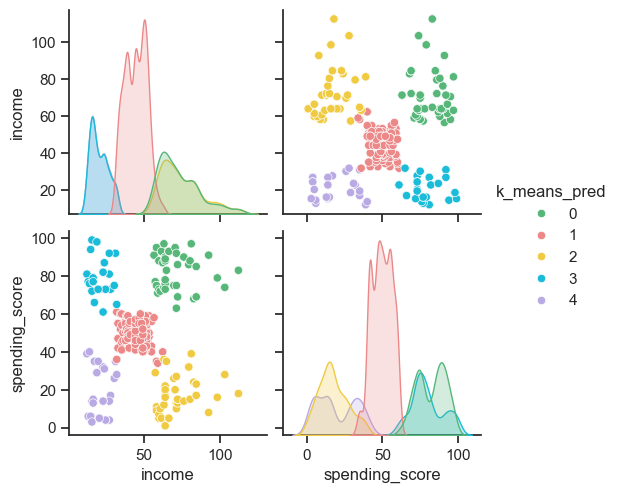

In [407]:
cluster(turt_k, 5)

**Observation:** Clear visual distinction between the 5 clusters.

### Option 2: 4 clusters

Value Counts: k_means_pred
1    1045
0     356
2     330
3     269
Name: count, dtype: int64
% of Total: k_means_pred
1    0.5225
0    0.1780
2    0.1650
3    0.1345
Name: proportion, dtype: float64


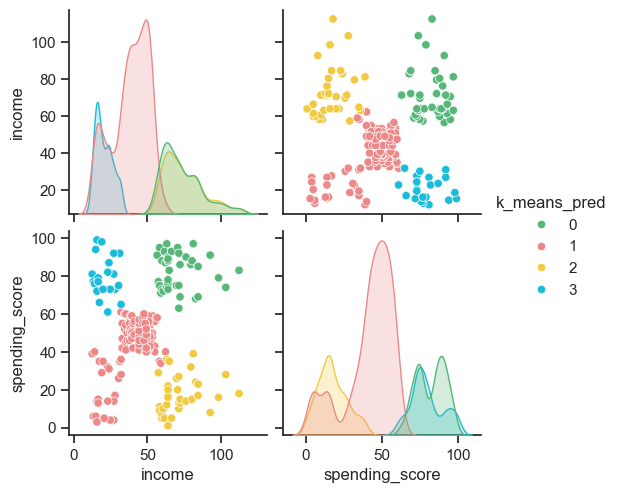

In [410]:
cluster(turt_k, 4)

**Observation:** While reducing number of clusters may be convenient for marketing purposes, this option loses distinctiveness of the bottom-left-quadrant cluster.

### Option 3: 3 clusters

Value Counts: k_means_pred
1    1220
0     429
2     351
Name: count, dtype: int64
% of Total: k_means_pred
1    0.6100
0    0.2145
2    0.1755
Name: proportion, dtype: float64


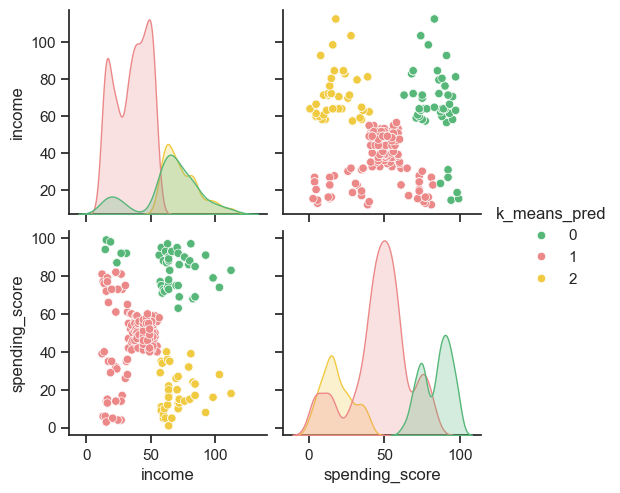

In [413]:
cluster(turt_k, 3)

**Observation:** This model flattens the customer base too much to be useful.

## Fit final model (*k* = 5)

Value Counts: k_means_pred
1    774
0    356
2    330
4    271
3    269
Name: count, dtype: int64
% of Total: k_means_pred
1    0.3870
0    0.1780
2    0.1650
4    0.1355
3    0.1345
Name: proportion, dtype: float64


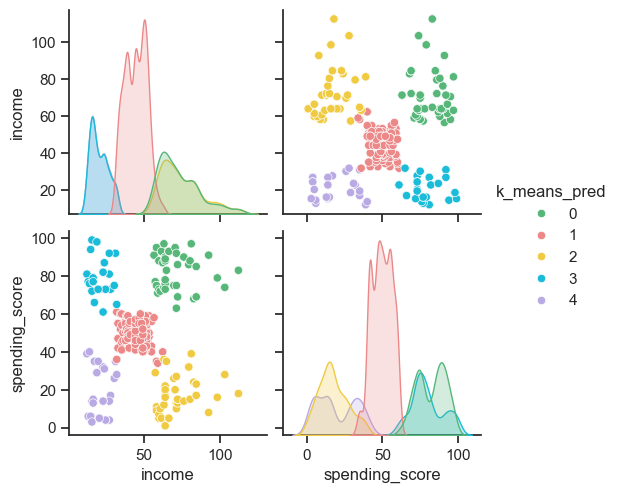

In [416]:
# Apply the final model.
cluster(turt_k, 5)

## Plot and interpret the clusters

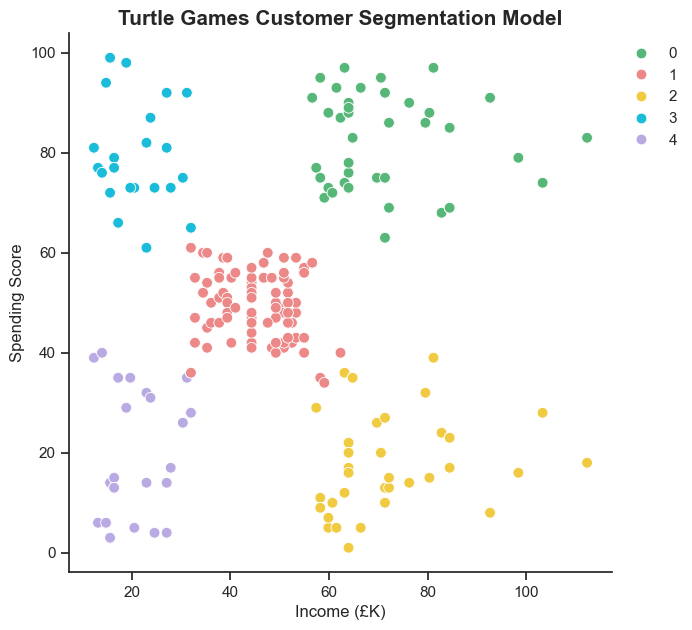

In [418]:
# Visualise the clusters
plt.figure(figsize=(7,7))
sns.set_style('ticks', {'axes.spines.top': False,
                        'axes.spines.right': False})

sns.scatterplot(y='spending_score',
                x='income',
                data=turt_k,
                hue='k_means_pred',
                palette=turt_cols,
                s=60)

# Set labels, title and legend
plt.title ('Turtle Games Customer Segmentation Model', fontsize=15, weight='bold')
plt.ylabel('Spending Score')
plt.xlabel('Income (£K)')
plt.legend(title=False, frameon=False, bbox_to_anchor=(1,1))

plt.savefig('segments.png', dpi=300)
plt.show()

In [419]:
# Add clusters to main df
turt4['cluster'] = turt_k['k_means_pred']

print(turt4.cluster.value_counts())
print(turt4.cluster.value_counts(normalize=True))

cluster
1    774
0    356
2    330
4    271
3    269
Name: count, dtype: int64
cluster
1    0.3870
0    0.1780
2    0.1650
4    0.1355
3    0.1345
Name: proportion, dtype: float64


In [420]:
# View information about the different clusters
for i in range(5):
    cluster_members = turt4[turt4['cluster'] == i]
    print(f'CLUSTER {i}:')
    print(f'Size: n={len(cluster_members)}, {round(len(cluster_members)/2000 * 100)}% of total')
    print()
    print(f'Avg age: {cluster_members['age'].mean():.0f}')
    print(f'Avg income: £{cluster_members['income'].mean():.0f}K')
    print(f'Avg spending score: {cluster_members['spending_score'].mean():.0f}')
    print(f'Avg loyalty pts: {cluster_members['loyalty_points'].mean():.0f}')
    print()
    print(cluster_members['gender'].value_counts(normalize=True)*100)
    print()
    print(cluster_members['education'].value_counts(normalize=True)*100)    
    print()
    print('-'*50)
    print()

CLUSTER 0:
Size: n=356, 18% of total

Avg age: 36
Avg income: £73K
Avg spending score: 82
Avg loyalty pts: 3988

gender
Female    55.05618
Male      44.94382
Name: proportion, dtype: float64

education
university         53.370787
advanced_degree    34.269663
lower_edu          12.359551
Name: proportion, dtype: float64

--------------------------------------------------

CLUSTER 1:
Size: n=774, 39% of total

Avg age: 42
Avg income: £44K
Avg spending score: 50
Avg loyalty pts: 1420

gender
Female    57.622739
Male      42.377261
Name: proportion, dtype: float64

education
university         44.832041
advanced_degree    43.927649
lower_edu          11.240310
Name: proportion, dtype: float64

--------------------------------------------------

CLUSTER 2:
Size: n=330, 16% of total

Avg age: 41
Avg income: £75K
Avg spending score: 17
Avg loyalty pts: 912

gender
Male      52.424242
Female    47.575758
Name: proportion, dtype: float64

education
advanced_degree    51.515152
university      

## Observations on Clustering Analysis

- Five clusters preserve the distinctiveness of each cluster
- The business has the option to prioritise 2-3 core customer groups from these five
- Cluster descriptions/recommendations will be discussed in the final presentation, summary below

#### Customer Segments

**MVPs (high income, high spend) – cluster 0**  
Key characteristics:
- Big spenders, loyal customers
- Highest loyalty points, income tier, and spending score
- A bit younger than average

Implications: 
- High-priority segment
- Candidates for premium loyalty programmes; VIP offers, early-access to new products
- Leverage as potential brand advocates - e.g. 'MVP Club'

**Core customers (mid-range) – cluster 1**  
Key characteristics:
- Largest cohort, representing the 'average' customer
- Medium spend and income

Implications: 
- Monitor behaviour to understand overall base
- Ideal group for testing new offerings to understand general appeal
- Focus on incremental spend/frequency increases through loyalty programmes

**Premium Prospects (high income, low spend) – cluster 2**  
Key characteristics:
- Highest income and education but lowest spending score
- Skewed male

Implications: 
- Significant uncaptured revenue potential
- Focus on luxury and exclusivity to appeal to high-status mindset
- Promote benefits of loyalty programme to drive continued engagement
- Conduct further analysis on behaviour and purchasing patterns needed to understand gap between spend and overall purchasing power

**Rising Stars (low income, high spend) – cluster 3**  
Key characteristics:
- Demonstrated willingness to buy products they value despite lower income
- Youngest average age, highly educated, lowest income tier (possibly due to early career stage)
- Smallest cluster

Implications: 
- Potential to develop into high-value loyal customers
- Focus on building loyalty through entry-level premium offering
- Target social-media strategies for younger demo
- Explore trend-forward products and advertising

**Value Seekers (Low-income, low spend) – cluster 4**

Key characteristics:
- Oldest average age, lower income, skewed female
- Low engagement

Implications:
- Lower-priority group overall
- Lower-priced essentials ranges could appeal
- Promote seasonal sales and clearances
- Target gift-giving times such as Christmas as some in this group may be purchasing primarily for children's gifts

# 

# Week 4: NLP

## Library imports

In [426]:
# Import all the necessary packages.
import pandas as pd
import numpy as np
import nltk 
import os 
import matplotlib.pyplot as plt
from datetime import datetime

# nltk.download ('punkt').
# nltk.download ('stopwords').

import string
import contractions
from collections import defaultdict
from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.models import Phrases
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle


# Import Counter.
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## Check data

In [428]:
# Create a copy - using turt4 for comparison of different clusters later in sentiment analysis
turt6 = turt4.copy().reset_index(drop=True)

# View DataFrame.
turt6.head()

gender  age  income  spending_score  loyalty_points   education  product  \
0    Male   18   12.30              39             210  university      453   
1    Male   23   12.30              81             524  university      466   
2  Female   22   13.12               6              40  university      254   
3  Female   25   13.12              77             562  university      263   
4  Female   33   13.94              40             366  university      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  cluster  
0  The fact that 50% of this space is wasted on a...        4  
1  Another worthless Dungeon Master's screen from...        3  
2                    pretty, but also pretty useless        4  
3                                         Five Stars        3  
4                                         Money trap        4

In [429]:
# Explore data set.
print(turt6.info())
turt6.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   income          2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
 9   cluster         2000 non-null   int32  
dtypes: float64(1), int32(1), int64(4), object(4)
memory usage: 148.6+ KB
None


age       income  spending_score  loyalty_points       product  \
count  2000.000000  2000.000000     2000.000000     2000.000000   2000.000000   
mean     39.495000    48.079060       50.000000     1578.032000   4320.521500   
std      13.573212    23.123984       26.094702     1283.239705   3148.938839   
min      17.000000    12.300000        1.000000       25.000000    107.000000   
25%      29.000000    30.340000       32.000000      772.000000   1589.250000   
50%      38.000000    47.150000       50.000000     1276.000000   3624.000000   
75%      49.000000    63.960000       73.000000     1751.250000   6654.000000   
max      72.000000   112.340000       99.000000     6847.000000  11086.000000   

           cluster  
count  2000.000000  
mean      1.662500  
std       1.289351  
min       0.000000  
25%       1.000000  
50%       1.000000  
75%       3.000000  
max       4.000000

In [430]:
# Keep necessary columns. 
turt_revs = turt6[['review', 'summary', 'product', 'cluster']].copy()  # Product has been included to match up pos/neg reviews with products

# View DataFrame.
pd.reset_option('display.max_colwidth')
turt_revs.head()

review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  product  cluster  
0  The fact that 50% of this space is wasted on a...      453        4  
1  Another worthless Dungeon Master's screen from...      466        3  
2                    pretty, but also pretty useless      254        4  
3                                         Five Stars      263        3  
4                                         Money trap      291        4

In [431]:
# Determine if there are any missing values.
turt_revs.isna().sum()

review     0
summary    0
product    0
cluster    0
dtype: int64

## Prepare the data for NLP

### Clean text

In [434]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e 'I'm' to 'I am' 
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    # Set stopwords
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words and word.isalnum()])
    return text

In [435]:
# Clean all text in review and summary cols
# See function at beginning of section
turt_revs['review_clean'] = turt_revs['review'].apply(preprocess_text)
turt_revs['summary_clean'] = turt_revs['summary'].apply(preprocess_text)

# View output
pd.set_option('display.max_colwidth', None)  # Show entirity of columns
turt_revs.head()

review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  When it comes to a DM's screen, the space on the screen itself is at an absolute premium. The fact that 50% of this space is wasted on art (and not terribly informative or needed art as well) makes it completely useless. The only reason that I gave it 2 stars and not 1 was that, technically speaking, it can at least still stand up to block your notes and dice rolls. Other than that, it drops the ball completely.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           An Open Letter to GaleForce9*:\n\nYour unpainted miniatures are very not bad. Your spell cards are great. Your board games are "meh". Your DM screens, however, are freaking terrible. I'm still waiting for a single screen that isn't polluted with pointless artwork where useful, reference-able tables should be. Once again, you've created a single use screen that is only useful when running the "Storm King's Thunder" adventure. Even despite the fact that it's geared to that adventure path, it's usefulness negligible, at best. I massive swath of the inner panel is wasted on artwork and a bloated overland map, which could have been easily reduced to a single panel in size. And the few table you have are nigh-useless themselves.\n\nIn short, stop making crap DM screens.   
2  Nice art, nice printing.  Why two panels are filled with a general Forgotten Realms map is beyond me.  Most of one of them is all blue ocean.  Such a waste.\n\nI don't understand why they can't make these DM Screens more useful for these "kinds of adventures" rather than solely the specific adventure.  You're supposed to be able to transpose this adventure to other lands outside the Forgotten Realms.  So even just a list of new monsters or NPCs would at least be useful than the map.  Even more would just be stuff related to running the game but broad-use stuff related to giants.\n\nSame thing with Curse of Strahd.  Why not make it useful for raven loft, undead or horror campaigns in general... instead a huge amount of screen space is solely mapping out Castle Ravenloft, which is only useful during a small fraction of the time even for the Curse of Strahd adventure, let alone various other Ravenloft adventuring.\n\nThey really kill the extended use of these screens by not thinking about their potential use, both for the adventure in question, as well as use in a broader sense.\n\nThe Rage of Demons screen is fa

In [436]:
# Check duplicates
print(turt_revs.duplicated(subset=['summary_clean']).sum())
print(turt_revs.duplicated(subset=['review_clean']).sum())
print(turt_revs.duplicated(subset=['review_clean', 'summary_clean']).sum())

704
73
56


**Note:** 
- These duplicates have been manually checked in Excel and appear legitimate (short reviews and summaries that have been reduced to short phrases or one word).
- They will not be deleted as this would artificially reduce frequency counts of some words and skew analysis of real-world sentiment.
- More conservative management that balances the data while preserving its integrity - such as weighting of repetitive reviews or removal of overly common words with stopwords - could be considered in future analysis.

### Tokenise text

In [439]:
# Tokenise
turt_revs['review_tokens'] = turt_revs['review_clean'].apply(word_tokenize)
turt_revs['summary_tokens'] = turt_revs['summary_clean'].apply(word_tokenize)

# View DataFrame.
pd.reset_option('display.max_colwidth') 
turt_revs.sample(5)

review  \
1621  I love the old lady doll.  My granddaughter lo...   
166                         love this delivered on time   
518      Great game. Kids love to play again and again.   
94                                                great   
1636  My 2.5 year old loves this puzzle. The large, ...   

                                             summary  product  cluster  \
1621  There Was an Old Lady Who Swallowed a Fly doll      405        1   
166                                       Five Stars    11084        2   
518                                       Mad dragon     5429        1   
94                                        Five Stars     6721        1   
1636                                    Great puzzle     9596        1   

                                           review_clean  \
1621  love old lady doll granddaughter loves story b...   
166                                 love delivered time   
518                           great game kids love play   
94                                                great   
1636  2 5 year old loves puzzle large thick pieces e...   

                    summary_clean  \
1621  old lady swallowed fly doll   
166                    five stars   
518                    mad dragon   
94                     five stars   
1636                 great puzzle   

                                          review_tokens  \
1621  [love, old, lady, doll, granddaughter, loves, ...   
166                             [love, delivered, time]   
518                     [great, game, kids, love, play]   
94                                              [great]   
1636  [2, 5, year, old, loves, puzzle, large, thick,...   

                         summary_tokens  
1621  [old, lady, swallowed, fly, doll]  
166                       [five, stars]  
518                       [mad, dragon]  
94                        [five, stars]  
1636                    [great, puzzle]

### Lemmatise text

In [441]:
# Define the tag map for POS tagging
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags
lemma_function = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

In [442]:
# Lemmatise
turt_revs['review_lemm'] = turt_revs['review_tokens'].apply(lemmatize_tokens)
turt_revs['summary_lemm'] = turt_revs['summary_tokens'].apply(lemmatize_tokens)

turt_revs.head()

review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  product  cluster  \
0  The fact that 50% of this space is wasted on a...      453        4   
1  Another worthless Dungeon Master's screen from...      466        3   
2                    pretty, but also pretty useless      254        4   
3                                         Five Stars      263        3   
4                                         Money trap      291        4   

                                        review_clean  \
0  comes dm screen space screen absolute premium ...   
1  open letter galeforce9 unpainted miniatures no...   
2  nice art nice printing two panels filled gener...   
3             amazing buy bought gift new dm perfect   
4  review gf9 previous screens completely unneces...   

                                       summary_clean  \
0  fact 50 space wasted art not terribly informat...   
1  another worthless dungeon master screen galefo...   
2                         pretty also pretty useless   
3                                         five stars   
4                                         money trap   

                                       review_tokens  \
0  [comes, dm, screen, space, screen, absolute, p...   
1  [open, letter, galeforce9, unpainted, miniatur...   
2  [nice, art, nice, printing, two, panels, fille...   
3     [amazing, buy, bought, gift, new, dm, perfect]   
4  [review, gf9, previous, screens, completely, u...   

                                      summary_tokens  \
0  [fact, 50, space, wasted, art, not, terribly, ...   
1  [another, worthless, dungeon, master, screen, ...   
2                    [pretty, also, pretty, useless]   
3                                      [five, stars]   
4                                      [money, trap]   

                                         review_lemm  \
0  [come, dm, screen, space, screen, absolute, pr...   
1  [open, letter, galeforce9, unpainted, miniatur...   
2  [nice, art, nice, printing, two, panel, fill, ...   
3          [amaze, buy, buy, gift, new, dm, perfect]   
4  [review, gf9, previous, screen, completely, un...   

                                        summary_lemm  
0  [fact, 50, space, waste, art, not, terribly, i...  
1  [another, worthless, dungeon, master, screen, ...  
2                    [pretty, also, pretty, useless]  
3                                       [five, star]  
4                                      [money, trap]

## Word clouds

### Reviews word cloud

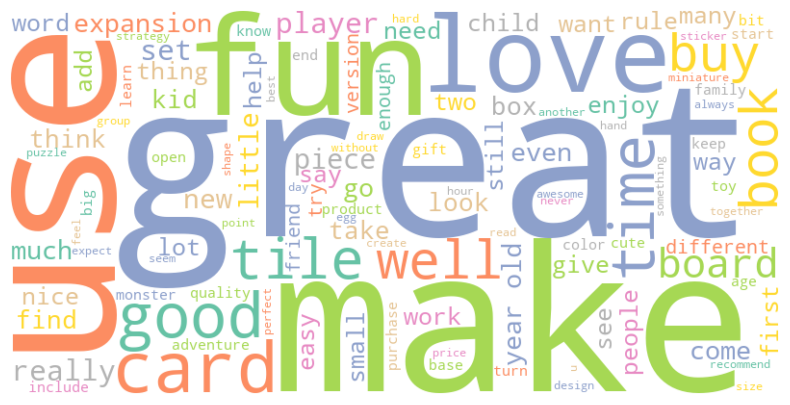

In [445]:
# Combine all words into a single string
review_words = ' '.join([' '.join(text) for text in turt_revs['review_lemm']])

# List of unwanted words
unwanted_words = ['game', 'play', 'one'] 

# Remove unwanted words
filtered_words = ' '.join([word for word in review_words.split() if word not in unwanted_words])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     min_font_size=10, max_words=150,
                     colormap='Set2').generate(filtered_words)

# Display the word cloud 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')

plt.savefig('wordcloud.png', dpi=300)
plt.show()

### Summary word cloud

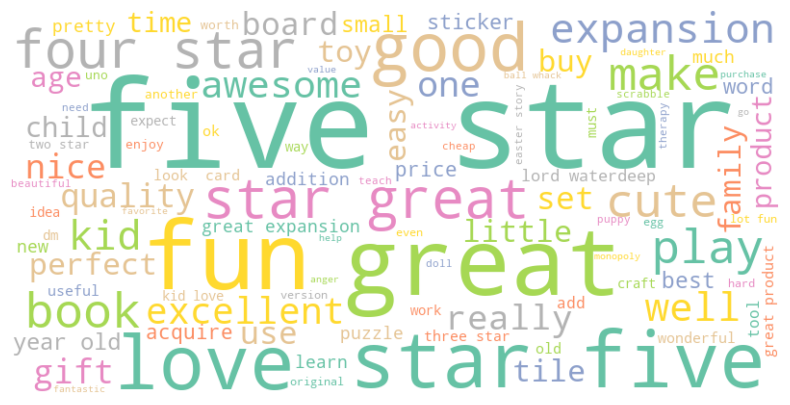

In [447]:
# Combine all words into a single string
summary_words = ' '.join([' '.join(text) for text in turt_revs['summary_lemm']])

# List of unwanted words
unwanted_words = ['game'] 

# Remove unwanted words
filtered_words = ' '.join([word for word in summary_words.split() if word not in unwanted_words])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     min_font_size=10, max_words=150,
                     colormap='Set2').generate(filtered_words)

# Display the word cloud 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')  
plt.show()

**Observations:**
- Word clouds allow a quick high-level view of some of the common words in the reviews.
- The review-summary word cloud works better for a word cloud because frequency appears more evenly distributed and emotive words are showcased more.
- Reviews seem to be generally positive, with words such as 'fun' and 'great' appearing prominently.
- However, viewing individual words from the total data set is of limited value. The words are devoid of context and contrast.
- Viewing difference between words in positive vs. negative reviews or different customer clusters may be more useful.
- Frequency breakdowns and n-gram analysis may also be more useful and create better visuals.

## Reviews freq dist

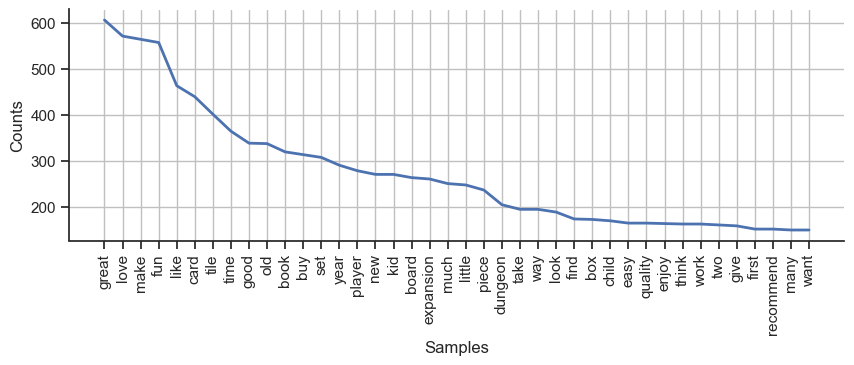

In [450]:
# Move all review tokens into 1 cell
all_review_words = []

unwanted_words = ['game', 'play', 'not', 'one',
                 'really', 'also', 'add', 'come',
                 'could', 'even', 'lot', 'get' ,'use',
                 '3', 'go', 'would', 'well'] 

for i in turt_revs['review_lemm']:
    all_review_words.extend([word for word in i if word not in unwanted_words])

# Determine the frequency distribution.
reviews_fdist = FreqDist(all_review_words)

plt.figure(figsize=(10,3))
reviews_fdist.plot(40)
plt.show()

**Observation:** 
- The default FreqDist chart is not ideal for seeing words and counts.
- A bar plot has been created below to clarify the data.
- Note: additional stopwords have been removed in attempts to include more meaningful words.  That said, choice of words is subjective.

In [452]:
# Use counter to create a frequency df
counts = pd.DataFrame(Counter(all_review_words).most_common(15),
                      columns=['Word', 'Frequency'])

counts.head()

Word  Frequency
0  great        607
1   love        572
2   make        565
3    fun        558
4   like        464

**Note:** Selected bar colours have been changed in chart below for use in pptx presentation.

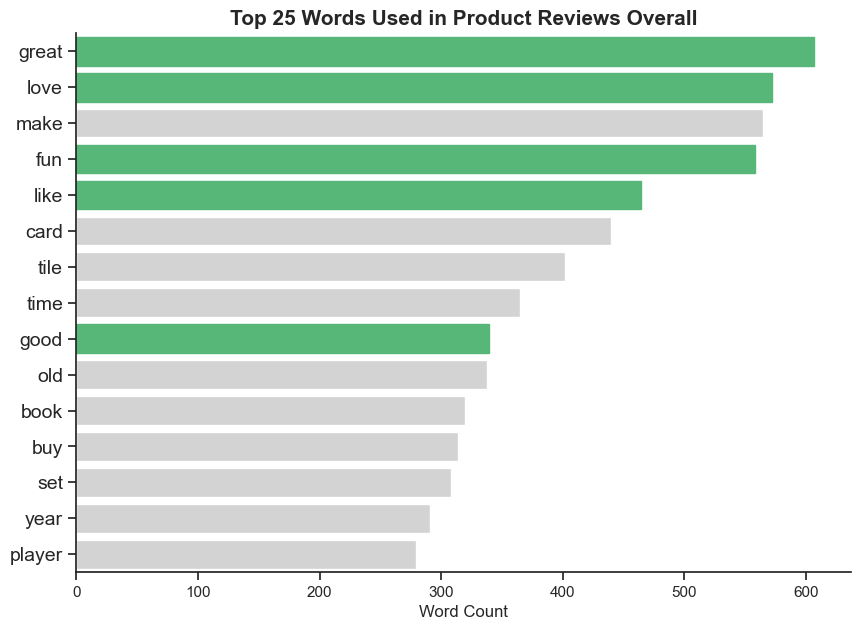

In [454]:
# Create a bar plot
plt.figure(figsize=(10,7))
sns.set_style('ticks', {'axes.spines.top': False,
                        'axes.spines.right': False})

ct = sns.barplot(data=counts, y='Word', x='Frequency', color='lightgrey')

# Change col of some bars
bars_to_change = [0, 1, 3, 4, 8]  
for i in bars_to_change:
    ct.patches[i].set_color('#56b779')

# Increase font size
plt.yticks(fontsize=14) 

# Set title and labels
plt.title('Top 25 Words Used in Product Reviews Overall', fontsize=15, weight='bold')
plt.ylabel('')
plt.xlabel('Word Count')

plt.savefig('all_words.png', dpi=300)
plt.show()

## Sentiment analysis

### TextBlob

In [457]:
# Make a new df copy
turt_tb = turt_revs.copy()
pd.reset_option('display.max_colwidth') 
turt_tb.sample(3)

review  \
1     An Open Letter to GaleForce9*:\n\nYour unpaint...   
1824          A quick to learn, fun and fast word game!   
200   I ordered this for my granddaughter for Christ...   

                                                summary  product  cluster  \
1     Another worthless Dungeon Master's screen from...      466        3   
1824                                     Fun with words     3878        3   
200                                     Pom Pom Puppies      466        4   

                                           review_clean  \
1     open letter galeforce9 unpainted miniatures no...   
1824                     quick learn fun fast word game   
200          ordered granddaughter christmas loved much   

                                          summary_clean  \
1     another worthless dungeon master screen galefo...   
1824                                          fun words   
200                                     pom pom puppies   

                                          review_tokens  \
1     [open, letter, galeforce9, unpainted, miniatur...   
1824              [quick, learn, fun, fast, word, game]   
200    [ordered, granddaughter, christmas, loved, much]   

                                         summary_tokens  \
1     [another, worthless, dungeon, master, screen, ...   
1824                                       [fun, words]   
200                                 [pom, pom, puppies]   

                                            review_lemm  \
1     [open, letter, galeforce9, unpainted, miniatur...   
1824              [quick, learn, fun, fast, word, game]   
200       [order, granddaughter, christmas, love, much]   

                                           summary_lemm  
1     [another, worthless, dungeon, master, screen, ...  
1824                                        [fun, word]  
200                                   [pom, pom, puppy]

**Note:** 
- TextBlob has been tested on both review_lemm and review_clean.
- After manually inspecting the reviews (see the 'Top pos/neg reviews' section below), it was found that review_clean more accurately identifies negative reviews. Therefore, review_clean has been used here. You will find the code for lemmatized text commented out below.

In [459]:
# TextBlob functions for polarity and subjectivity
def generate_polarity(comment):
    '''Extract polarity score (-1 to +1) for each comment'''
    return TextBlob(comment).sentiment[0]

def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

In [460]:
# Determine polarity and subjectivity of both columns. 
turt_tb['review_polarity'] = turt_tb['review_clean'].apply(generate_polarity)
turt_tb['summary_polarity'] = turt_tb['summary_clean'].apply(generate_polarity)
turt_tb['review_subjectivity'] = turt_tb['review_clean'].apply(generate_subjectivity)
turt_tb['summary_subjectivity'] = turt_tb['summary_clean'].apply(generate_subjectivity)

# Lemmatised text must first be rejoined into text - NOTE: LEMMATISED TEXT HAS NOT BEEN USED (SEE MARKDOWN COMMENT ABOVE)
# turt_tb['review_polarity'] = turt_tb['review_lemm'].apply(lambda x: generate_polarity(' '.join(x)))
# turt_tb['summary_polarity'] = turt_tb['summary_lemm'].apply(lambda x: generate_polarity(' '.join(x)))
# turt_tb['review_subjectivity'] = turt_tb['review_lemm'].apply(lambda x: generate_subjectivity(' '.join(x)))
# turt_tb['summary_subjectivity'] = turt_tb['summary_lemm'].apply(lambda x: generate_subjectivity(' '.join(x)))

# View output.
turt_tb.head(2)

review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   

                                             summary  product  cluster  \
0  The fact that 50% of this space is wasted on a...      453        4   
1  Another worthless Dungeon Master's screen from...      466        3   

                                        review_clean  \
0  comes dm screen space screen absolute premium ...   
1  open letter galeforce9 unpainted miniatures no...   

                                       summary_clean  \
0  fact 50 space wasted art not terribly informat...   
1  another worthless dungeon master screen galefo...   

                                       review_tokens  \
0  [comes, dm, screen, space, screen, absolute, p...   
1  [open, letter, galeforce9, unpainted, miniatur...   

                                      summary_tokens  \
0  [fact, 50, space, wasted, art, not, terribly, ...   
1  [another, worthless, dungeon, master, screen, ...   

                                         review_lemm  \
0  [come, dm, screen, space, screen, absolute, pr...   
1  [open, letter, galeforce9, unpainted, miniatur...   

                                        summary_lemm  review_polarity  \
0  [fact, 50, space, waste, art, not, terribly, i...        -0.028571   
1  [another, worthless, dungeon, master, screen, ...         0.037845   

   summary_polarity  review_subjectivity  summary_subjectivity  
0              0.15             0.428571                   0.5  
1             -0.80             0.436028                   0.9

In [461]:
# View statistical summary of scores 
turt_tb.describe()

product      cluster  review_polarity  summary_polarity  \
count   2000.000000  2000.000000      2000.000000       2000.000000   
mean    4320.521500     1.662500         0.208304          0.214729   
std     3148.938839     1.289351         0.270661          0.339568   
min      107.000000     0.000000        -1.000000         -1.000000   
25%     1589.250000     1.000000         0.024922          0.000000   
50%     3624.000000     1.000000         0.175000          0.050000   
75%     6654.000000     3.000000         0.358750          0.450000   
max    11086.000000     4.000000         1.000000          1.000000   

       review_subjectivity  summary_subjectivity  
count          2000.000000           2000.000000  
mean              0.514632              0.374896  
std               0.198237              0.342573  
min               0.000000              0.000000  
25%               0.414047              0.000000  
50%               0.507321              0.400000  
75%               0.612954              0.633333  
max               1.000000              1.000000

#### Reviews - polarity and subjectivity

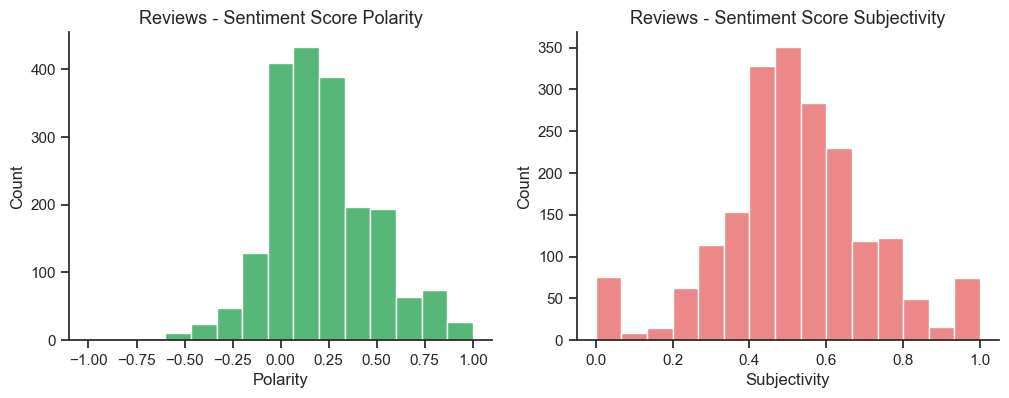

In [463]:
# Reviews: Create a histogram plot with bins = 15.
plt.figure(figsize=(12, 4))

# Histogram of polarity
plt.subplot(1,2,1)
plt.hist(turt_tb['review_polarity'], bins=15, color='#56b779')
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Reviews - Sentiment Score Polarity', fontsize=13)

# Histogram of subjectivity
plt.subplot(1,2,2)
plt.hist(turt_tb['review_subjectivity'], bins=15, color='#EC8888')
plt.xlabel('Subjectivity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Reviews - Sentiment Score Subjectivity', fontsize=13)

plt.show()

#### Summary - polarity and subjectivity

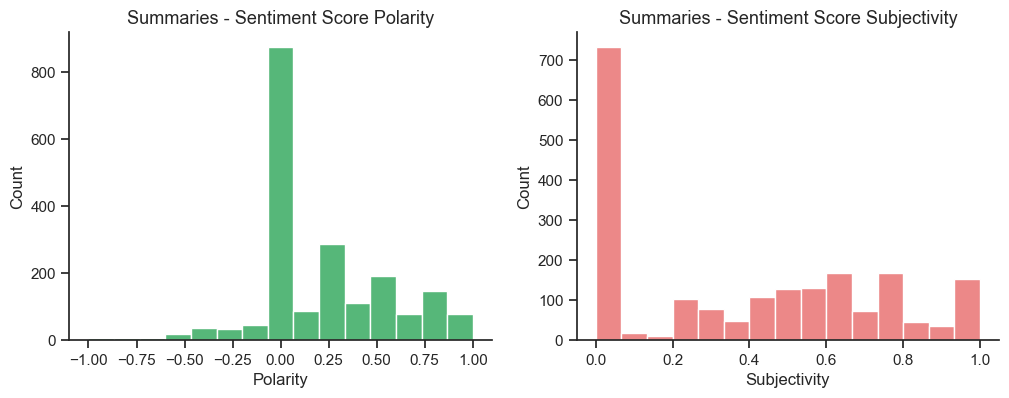

In [465]:
# Summary: Create a histogram plot with bins = 15
plt.figure(figsize=(12, 4))

# Histogram of polarity
plt.subplot(1,2,1)
plt.hist(turt_tb['summary_polarity'], bins=15, color='#56b779')
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Summaries - Sentiment Score Polarity', fontsize=13)

# Histogram of subjectivity
plt.subplot(1,2,2)
plt.hist(turt_tb['summary_subjectivity'], bins=15, color='#EC8888')
plt.xlabel('Subjectivity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Summaries - Sentiment Score Subjectivity', fontsize=13)

plt.show()

**Observation on polarity reviews vs. summaries:** 
- Review summaries have a flattening effect on both polarity and subjectivity of reviews.
- Using full reviews is a better option for tracking sentiment analysis and will be used going forward.

In [467]:
# Generate polarity groupings
turt_tb['textblob_polarity']=''
turt_tb.loc[turt_tb.review_polarity>0,'textblob_polarity']='Positive'
turt_tb.loc[turt_tb.review_polarity==0,'textblob_polarity']='Neutral'
turt_tb.loc[turt_tb.review_polarity<0,'textblob_polarity']='Negative'

turt_tb.sample(3)

review  \
955  Fun game with LOTS of options.  Good way to ge...   
227  this was a gift for my daughter.  I found it d...   
486  Super easy familiar format.  I bought it for t...   

                                             summary  product  cluster  \
955                                       Five Stars    11004        0   
227                                        Two Stars      231        3   
486  Yes! Buy them! Wish the company had other sets.      948        1   

                                          review_clean  \
955         fun game lots options good way get started   
227                  gift daughter found difficult use   
486  super easy familiar format bought therapy clie...   

                 summary_clean  \
955                 five stars   
227                  two stars   
486  yes buy wish company sets   

                                         review_tokens  \
955  [fun, game, lots, options, good, way, get, sta...   
227            [gift, daughter, found, difficult, use]   
486  [super, easy, familiar, format, bought, therap...   

                      summary_tokens  \
955                    [five, stars]   
227                     [two, stars]   
486  [yes, buy, wish, company, sets]   

                                           review_lemm  \
955    [fun, game, lot, option, good, way, get, start]   
227             [gift, daughter, find, difficult, use]   
486  [super, easy, familiar, format, buy, therapy, ...   

                       summary_lemm  review_polarity  summary_polarity  \
955                    [five, star]         0.200000               0.0   
227                     [two, star]        -0.500000               0.0   
486  [yes, buy, wish, company, set]         0.305937               0.0   

     review_subjectivity  summary_subjectivity textblob_polarity  
955             0.400000                   0.0          Positive  
227             1.000000                   0.0          Negative  
486             0.650833                   0.0          Positive

#### Distribution of polarity groupings

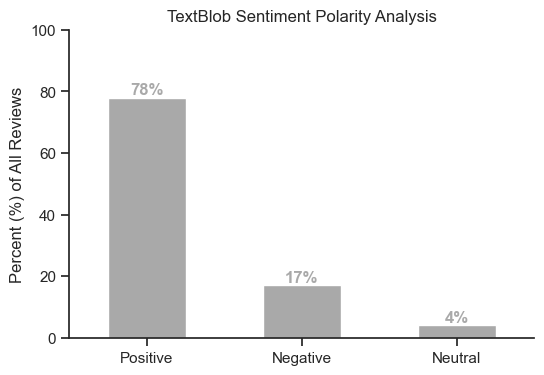

In [469]:
# View polarity groupings - bar chart
plt.figure(figsize=(6,4))
sns.set_style('ticks', {
       'axes.spines.top': False,     # Removes top axis line
       'axes.spines.right': False})  # Removes right axis line

# Plot
ax = turt_tb.textblob_polarity.value_counts(normalize=True).mul(100).round().plot(kind='bar', color='darkgrey')

# Show data labels
for i in ax.containers:
   ax.bar_label(i, fmt='%.0f%%', color='darkgrey', weight='bold')

# Set labels and title
ax.set(xlabel = None,
                ylabel = 'Percent (%) of All Reviews',
                title='TextBlob Sentiment Polarity Analysis')

# Format axes
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.savefig('sentiment_groups.png', dpi=300)
plt.show()

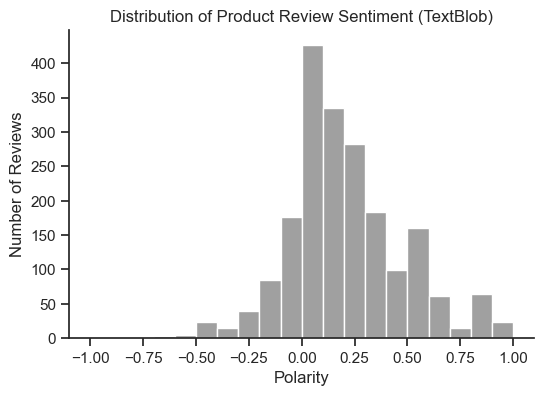

In [470]:
# View distribution of polarity groupings - histogram
plt.figure(figsize=(6,4))

sns.histplot(data=turt_tb, x='review_polarity', 
             bins=20, color='grey')

# Set labels and title
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Product Review Sentiment (TextBlob)')

plt.savefig('sentiment_hist_grey.png', dpi=300)
plt.show()

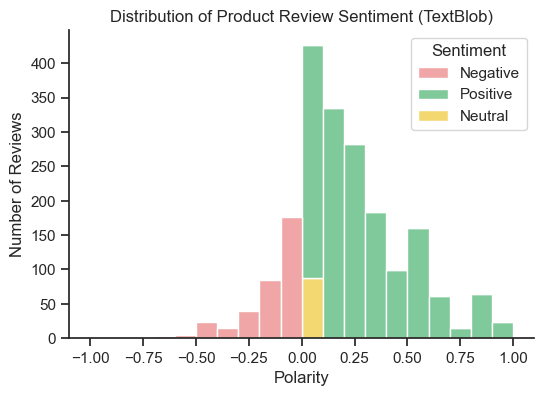

In [471]:
# View distribution of polarity groupings - histogram
plt.figure(figsize=(6,4))

sns.histplot(data=turt_tb, x='review_polarity', hue='textblob_polarity', 
             bins=20, palette=['#EC8888', '#56b779', '#F0CA41'], multiple='stack')

# Set labels and title
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Product Review Sentiment (TextBlob)')

# Set legend
legend = plt.gca().get_legend()
legend.set_title('Sentiment')

plt.savefig('sentiment_hist.png', dpi=300)
plt.show()

In [472]:
# View average polarity by cluster
(turt_tb.groupby('cluster')['review_polarity'].mean() * 100).round(0)

cluster
0    22.0
1    19.0
2    23.0
3    22.0
4    20.0
Name: review_polarity, dtype: float64

### VADER for comparison

**Note:** 
- Both reviews and summaries have been analysed. However, just reviews are shown below for comparison to TextBlob.
- Both lemmatised and clean text has been tested. Variation is minimal, so lemmatised text is used below.

In [475]:
# Create a df copy
turt_vad = turt_revs.copy()
turt_vad = turt_vad[['cluster', 'review', 'review_clean', 'review_lemm', 'summary_clean']]

In [476]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [477]:
# Apply VADER sentiment analyser
turt_vad['vader_sentiment'] = turt_vad['review_lemm'].apply(analyze_sentiment)

# Expand scores to separate cols
turt_vad = turt_vad.join(turt_vad['vader_sentiment'].apply(pd.Series))

# Drop original vader col
turt_vad = turt_vad.drop(columns=['vader_sentiment'])

# Add VADER sentiment groupings
turt_vad['Sentiment']=''
turt_vad.loc[turt_vad.compound >= 0.05,'Sentiment']='Positive'
turt_vad.loc[(turt_vad.compound > -0.05) & (turt_vad.compound < 0.05),'Sentiment']='Neutral'
turt_vad.loc[turt_vad.compound <= -0.05,'Sentiment']='Negative'

pd.reset_option('display.max_colwidth')
turt_vad.head()

cluster                                             review  \
0        4  When it comes to a DM's screen, the space on t...   
1        3  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2        4  Nice art, nice printing.  Why two panels are f...   
3        3  Amazing buy! Bought it as a gift for our new d...   
4        4  As my review of GF9's previous screens these w...   

                                        review_clean  \
0  comes dm screen space screen absolute premium ...   
1  open letter galeforce9 unpainted miniatures no...   
2  nice art nice printing two panels filled gener...   
3             amazing buy bought gift new dm perfect   
4  review gf9 previous screens completely unneces...   

                                         review_lemm  \
0  [come, dm, screen, space, screen, absolute, pr...   
1  [open, letter, galeforce9, unpainted, miniatur...   
2  [nice, art, nice, printing, two, panel, fill, ...   
3          [amaze, buy, buy, gift, new, dm, perfect]   
4  [review, gf9, previous, screen, completely, un...   

                                       summary_clean    neg    neu    pos  \
0  fact 50 space wasted art not terribly informat...  0.223  0.675  0.103   
1  another worthless dungeon master screen galefo...  0.191  0.534  0.276   
2                         pretty also pretty useless  0.202  0.584  0.213   
3                                         five stars  0.000  0.284  0.716   
4                                         money trap  0.370  0.630  0.000   

   compound Sentiment  
0   -0.7067  Negative  
1    0.8679  Positive  
2   -0.2310  Negative  
3    0.8779  Positive  
4   -0.7063  Negative

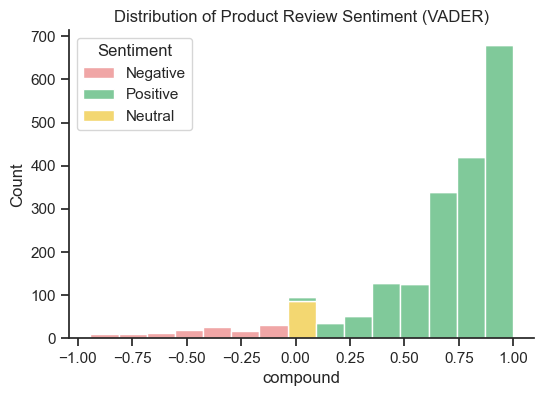

In [478]:
# Create a histogram to show the values
plt.figure(figsize=(6,4))

sns.histplot(data=turt_vad, x='compound', hue='Sentiment', 
             bins=15, palette=['#EC8888', '#56b779', '#F0CA41'], multiple='stack')

plt.title('Distribution of Product Review Sentiment (VADER)')

plt.show()

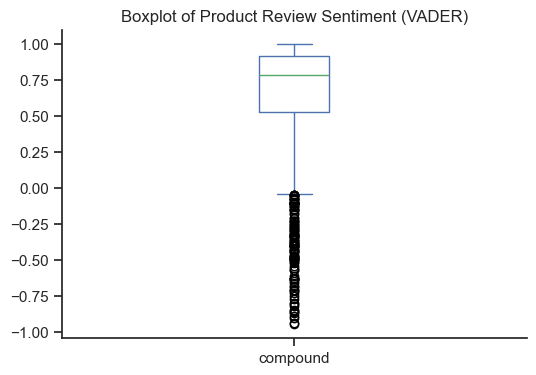

In [479]:
# Create a boxplot to display the values for a different view
plt.figure(figsize=(6,4))
_plot = turt_vad.reset_index()['compound'].sort_values()
_plot.plot(kind='box')
plt.title('Boxplot of Product Review Sentiment (VADER)')
plt.show()

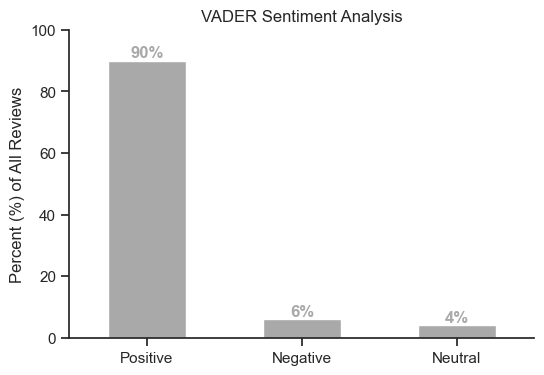

In [480]:
# View distribution of polarity groupings
plt.figure(figsize=(6,4))
ax = turt_vad.Sentiment.value_counts(normalize=True).mul(100).round().plot(kind='bar', color='darkgrey')

# Show data labels
for i in ax.containers:
   ax.bar_label(i, fmt='%.0f%%', color='darkgrey', weight='bold')

# Set axis labels and title
ax.set(xlabel = None,
                ylabel = 'Percent (%) of All Reviews',
                title='VADER Sentiment Analysis')

# Format axes
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

In [481]:
# View average compound by cluster
(turt_vad.groupby('cluster')['compound'].mean() * 100).round(0)

cluster
0    63.0
1    68.0
2    63.0
3    64.0
4    62.0
Name: compound, dtype: float64

**Observations on VADER vs. TextBlob:**
- VADER distribution is more positive that TextBlob distribtion (90% positive for VADER reviews vs. 78% positive for TextBlob).
- Next steps: Manually tag a sample of reviews and compare VADER vs. TextBlob to determine which is more accurate for this data set.
- Difference in avg. review sentiment between TextBlob and VADER by customer clusters also support the idea that further manual review and testing is needed.

### Top pos/neg reviews
**Notes:** 
- TextBlob will be used for this section for simplicity and because it has identified a higher percentage of negative reviews.
- More attention and analysis will go toward negative reviews as these are more important for the business to address.

#### Negative

In [485]:
# Top 20 negative reviews
neg_revs = turt_tb.nsmallest(20, 'review_polarity')
neg_revs = neg_revs[['review', 'review_lemm', 'review_polarity', 'product']]

# View output.
pd.set_option('display.max_colwidth', None)  # Set cols to no max width
neg_revs[['review']]

review
208                                                                                                                                                                       BOOO  UNLES YOU ARE PATIENT KNOW HOW TO MEASURE I DIDN'T HAVE THE PATIENCE NEITHER DID MY DAUGHTER.  BORING UNLESS YOU ARE A CRAFT PERSON WHICH I AM NOT.
526                                                                                                                                                                                          Keeps clients engaged while helping them develop anger management skills. The only criticism is I wish more of the cards had questions
527                                                                                                                                                                               Used with anger-management group and they like it.\nGave them opportunity to share events in their life with\nthe usage of the cues on the cards.
174   I sent this product to my granddaughter. The pom-pom maker comes in two parts and is supposed to snap together to create the pom-poms. However, both parts were the same making it unusable. If you can't make the pom-poms the kit is useless. Since this was sent as a gift, I do not have it to return. Very disappointed.
182                                                                                                                                                                                                                                                                                            Incomplete kit!  Very disappointing!
538                                                                                                                                                                       I purchased this on the recommendation of two therapists working with my adopted children. The children found it boring and put it down half way through.
1804                                                                                                                                                                                                                                                   I'm sorry. I just find this product to be boring and, to be frank, juvenile.
364                                                                                            One of my staff will be using this game soon, so I don't know how well it works as yet, but after looking at the cards, I believe it will be helpful in getting a conversation started regarding anger and what to do to control it.
117                                                                                                                                                                                                                   I bought this as a Christmas gift for my grandson.  Its a sticker book. So how can I go wrong with this gift.
173                                                                                                                                                                                                                                                               Horrible!\nNothing more to say\nWould give zero stars if possible
227                                                                                                                                                                                                                                                                   this was a gift for my daughter.  I found it difficult to use
230                                                                                                                                                                                                                                                                                                I found the directions difficult
290                                                                                                      

In [486]:
# Check if any specific products are more frequent in neg reviews
neg_revs[neg_revs['product'].map(neg_revs['product'].value_counts()) > 1]

review  \
227  this was a gift for my daughter.  I found it difficult to use   
427                               Kids I work with like this game.   

                                review_lemm  review_polarity  product  
227  [gift, daughter, find, difficult, use]             -0.5      231  
427                 [kid, work, like, game]             -0.4      231

In [487]:
# Top 20 negative summaries.
neg_summ = turt_tb.nsmallest(20, 'summary_polarity')
neg_summ = neg_summ[['review', 'summary_clean', 'summary_polarity', 'product']]

# View output.
pd.set_option('display.max_colwidth', 350) 
neg_summ[['review', 'summary_clean']]

review  \
21    These are cute tatoos for those who love pirates, however, the retail price is $1.50 and Amazon's price is MORE THAN DOUBLE.  I have never paid OVER the retail price for an item at Amazon.  I was shocked.  There are only a handful of tatoos, and for 1.50 I wouldn't mind, but to charge 3.50 for an item that sells anywhere else for 1.50 is crimin...   
173                                                                                                                                                                                                                                                                                               Horrible!\nNothing more to say\nWould give zero stars if possible   
208                                                                                                                                                                                                       BOOO  UNLES YOU ARE PATIENT KNOW HOW TO MEASURE I DIDN'T HAVE THE PATIENCE NEITHER DID MY DAUGHTER.  BORING UNLESS YOU ARE A CRAFT PERSON WHICH I AM NOT.   
829   I've discovered that I'm really "new school" when it comes to my board games.  Except for Boggle (and a couple Chess boards and a novelty version of Yahtzee), this is the oldest game I own by more than 30 years.\n\nIt's very watered down for my usual tastes.  Gameplay consists of playing tiles on a board to start, expand, or merge hotel chains....   
1166                                                                                                                                                             before this I hated running any RPG campaign dealing with towns because it kills the momentum and just becomes 2 hours of haggling for magic items. This helps open up story ideas and plot hooks.   
1     An Open Letter to GaleForce9*:\n\nYour unpainted miniatures are very not bad. Your spell cards are great. Your board games are "meh". Your DM screens, however, are freaking terrible. I'm still waiting for a single screen that isn't polluted with pointless artwork where useful, reference-able tables should be. Once again, you've created a single...   
144   MY kids grew up with a peg bench and hammer and loved it, but I bought this brand for my grandson and was disappointed. The pegs  fit too loosely into the bench and he does not even use his hammer to pound them in, as he can  just push them in with his hand, or sometimes they fall through automatically.  My suggestion is to make the pegs fit a ...   
631                                                                                                                                                                                                                                                                                                                                   Eggs split and were unusable.   
793   My mom already owned an Acquire game but she always commented on how poorly it was made. So, I thought I would get her a new one for Christmas. The quality of this one was not much better. Her old one had cards for each player to see how much each hotel cost to buy according to how many tiles it had. This one did not even have that. I expected ...   
1620                                                                                                                                            I was thinking it was a puppet but it is not,  it is a doll.  Still  worked for what I needed but the only way to get the animals in and out is through the mouth,  which is a little difficult for a little child.   
363   I found that this card game does the opposite of what it was intended for. It actually has the kids focusing on ways to get angry, etc. instead of teaching how to be calm and act better. It really should have been tested before sale. A better game would have been Calm Dragon. I tried this game on kids that had absolutely no behavior or anger pr...   
885                                      

In [488]:
# Check if any specific products are more frequent in neg review summaries
neg_summ[neg_summ['product'].map(neg_summ['product'].value_counts()) > 1]

Empty DataFrame
Columns: [review, summary_clean, summary_polarity, product]
Index: []

**Observation:** 
- Full reviews have been included because different records are returned when viewing lowest-polarity summaries.
- Despite flattening the sentiment scores, summariy polarity appears better at drawing out certain types of negative reviews, specifically longer reviews addressing quality (physical and conceptual) of games. Lowest-polarity reviews focus more on difficulty of crafts and puzzles.
- **Recommendation:** use review sentiment to monitor scores over time, but investigate both low-polarity reviews *and* reviews linked to low-polarity summaries to troubleshoot customer dissatisfaction and product issues.

#### Positive

In [491]:
# Top 20 positive reviews.
pos_revs = turt_tb.nlargest(20, 'review_polarity')
pos_revs = pos_revs[['review', 'review_lemm', 'review_polarity', 'product']]

# View output.
pos_revs

review  \
7                                                                   Came in perfect condition.   
165                                                                               Awesome book   
194                                                                               Awesome gift   
496                                    Excellent activity for teaching self-management skills!   
524                                                             Perfect, just what I ordered!!   
591                                                                          Wonderful product   
609                                                                        Delightful product!   
621                                 Wonderful for my grandson to learn the resurrection story.   
790                                                                                   Perfect!   
933                                                                                    Awesome   
1037                                                                                   Awesome   
1135                                                                              awesome set!   
1168                                                    best set. buy 2 if you have the means.   
1177                                                     Awesome addition to my rpg GM system.   
1301                                                                              It's awesome   
1401                                       One of the best board games I played in along time.   
1550                             My daughter loves her stickers! Awesome seller! Thank You! :)   
1609  this was perfect to go with the 7 bean bags , I just wish they were not separate orders.   
1715                                                                              Awesome toy!   
1720                     It is the best thing to play with and also mind -blowing in some ways   

                                                  review_lemm  \
7                                  [come, perfect, condition]   
165                                           [awesome, book]   
194                                           [awesome, gift]   
496     [excellent, activity, teach, self, management, skill]   
524                                          [perfect, order]   
591                                      [wonderful, product]   
609                                     [delightful, product]   
621         [wonderful, grandson, learn, resurrection, story]   
790                                                 [perfect]   
933                                                 [awesome]   
1037                                                [awesome]   
1135                                           [awesome, set]   
1168                                [best, set, buy, 2, mean]   
1177                     [awesome, addition, rpg, gm, system]   
1301                                                [awesome]   
1401              [one, best, board, game, play, along, time]   
1550        [daughter, love, sticker, awesome, seller, thank]   
1609  [perfect, go, 7, bean, bag, wish, not, separate, order]   
1715                                           [awesome, toy]   
1720               [best, thing, play, also, mind, blow, way]   

      review_polarity  product  
7                 1.0     1012  
165               1.0    11056  
194               1.0     9080  
496               1.0     3427  
524               1.0     8235  
591               1.0     8962  
609               1.0     1501  
621               1.0      618  
790               1.0     9080  
933               1.0     4477  
1037              1.0     2130  
1135              1.0     7384  
1168              1.0     6471  
1177              1.0     8923  
1301              1.0     5430  
1401              1.0      760  
1550              1.0     7101  
1609              1.0     3667  
1715              1.0     7600  
172

In [493]:
# Top 20 positive summaries.
pos_summ = turt_tb.nlargest(20, 'summary_polarity')
pos_summ = pos_summ[['review', 'summary_clean', 'summary_polarity', 'product']]

# View output.
pos_summ[['review']]

review
6                                                                                                                                                                     I have bought many gm screens over the years, but this one is the best I have ever seen. It has all the relevant information I need , and no crap filler on it. Very happy with this screen.
28                                                                                                                                                                                   These are intricate designs for older children and adults. This book is full of beautiful designs just waiting to be awakened by your choice of colors. Great for creativity.
32                                                                                                                                                                                                                                                Awesome! My 8 year old's favorite Xmas gift! It's 9:15 am xmas morning and he's already colored three of these!!
80                                                                                                                                                     My daughter loves these little books.  They're the perfect size to keep in the car or a diaper bag or purse.  I keep them on hand for times when we're stuck waiting in a doctor's office or anywhere else.
134               This occupied my almost-3 year old for nearly an hour.  Stickers were durable and easy to peel.  Afterwards, he kept going back to the box to see if there were more robot stickers to assemble in there.\n\nI'll probably drop another dollar and buy it again for his Christmas stocking.  Three cheers for the short memory of a preschooler!
140                                            I bought 8 of these for my 3 year old daughter's robot themed birthday party as favors for the little ones and it was a great hit! I didn't realize that the stickers were robot parts that the kids assemble themselves to create their own robots! That was a lot of fun and for the price, it was well worth it!
161                                                                                                                                                                                                                                                                                                    My 8 year old Son LOVES this Drawing Book.... LOVES IT!!!!!
187                                                                     Great product. Took a little practice and time, but after you get the hang of it. It turns into a cute cuddly little friend. Mine didn't turn out exactly like the picture, but it adds a taste of your own sense of style. They are super cute and comes with everything it says it will.
210  I was skeptical, but my 9 year old has had so much fun with this kit and it was her favorite Christmas present.  She pretty much made the puppies herself with minimal help from me, though I did hot glue some ears rather than use the included glue.  Only downside is the cuttings can be messy, but really wonderful instructions, well-made supplies...
418                                                                                                                                                                                                                                                           Great resource for BHIS care coordinators!! Works well with kids and teens on what it says it does!!
475                                                                                                                                                                                                                                                                                             This is a great anger management game for kiddos and adults alike!
543                                                                                     

## Pos/Neg Comparison Visualisations

### Word clouds - pos/neg comparison 

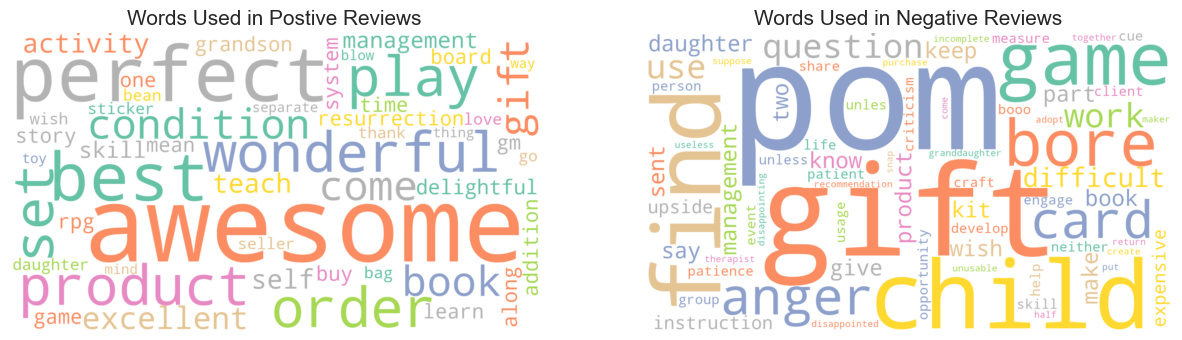

In [495]:
# Unify all review text
pos_text = ' '.join([' '.join(text) for text in pos_revs['review_lemm']])
neg_text = ' '.join([' '.join(text) for text in neg_revs['review_lemm']])


# Create a word cloud - pos
pos_text_cloud = WordCloud(width=1600, height=900,
                         min_font_size=10,
                         max_words=70,
                         background_color='white',
                         colormap='Set2').generate(pos_text)

# Create a word cloud - neg
neg_text_cloud = WordCloud(width=1600, height=900,
                         min_font_size=10,
                         max_words=70,
                         background_color='white',
                         colormap='Set2').generate(neg_text)


# Plot the word cloud
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.imshow(pos_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Postive Reviews', fontsize=15)

plt.subplot(1,2,2)
plt.imshow(neg_text_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words Used in Negative Reviews', fontsize=15)

plt.show()   

**Observations:** 
- Negative reviews cloud is useful for quickly pulling out words such as 'bore' and 'difficult', alluding to the reasons for negative review
- 'Pom' (assumed 'pompom') is also present, implying this crafting product may be less well-received
- 'Gift' is a prominent word, suggesting that gift givers may be less satisfied customers. This is something for the business to investigate further.

### Pos/Neg Comparison bar chart

In [497]:
# Create list of unwanted words
unwanted_words = ['game', 'play', 'not', 'one',
                 'really', 'also', 'add', 'come',
                 'could', 'even', 'lot', 'get' ,'use',
                 '3', 'go'] 

# Move all tokens into 1 cell 
all_pos_words = []

for i in pos_revs['review_lemm']:
    all_pos_words.extend([word for word in i if word not in unwanted_words])

all_neg_words = []

for i in neg_revs['review_lemm']:
    all_neg_words.extend([word for word in i if word not in unwanted_words])

In [499]:
pos_counts = pd.DataFrame(Counter(all_pos_words).most_common(15),
                          columns=['Word', 'Frequency'])

pos_counts.head()

Word  Frequency
0    awesome          9
1    perfect          4
2       best          3
3      order          2
4  wonderful          2

In [501]:
neg_counts = pd.DataFrame(Counter(all_neg_words).most_common(15),
                          columns=['Word', 'Frequency'])

neg_counts.head()

Word  Frequency
0    pom          6
1   gift          4
2  child          4
3   find          4
4   bore          3

**Note:** Selected bar colours have been changed in chart below for use in pptx presentation.

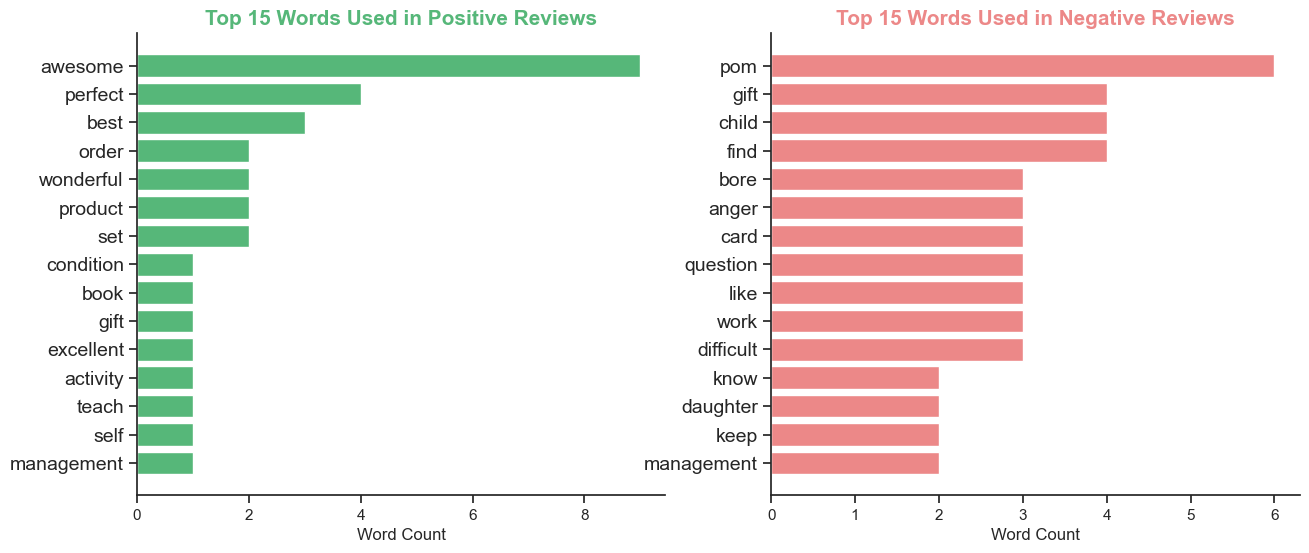

In [510]:
# Visualise results
plt.figure(figsize=(15,6))
sns.set_style('ticks', {'axes.spines.top': False,
                        'axes.spines.right': False})

plt.subplot(1,2,1)
ct = plt.barh(pos_counts.Word, pos_counts.Frequency, color='#56b779')
plt.gca().invert_yaxis()
plt.title('Top 15 Words Used in Positive Reviews', color='#56b779', fontsize=15, weight='bold')
plt.xlabel('Word Count')

# Change col of some bars
# bars_to_change = [0, 1, 2, 4, 10, 10]  
# for i in bars_to_change:
    # ct.patches[i].set_color('#56b779')

# Increase font size
plt.yticks(fontsize=14) 

plt.subplot(1,2,2)
ct = plt.barh(neg_counts.Word, neg_counts.Frequency, color='#EC8888')
plt.gca().invert_yaxis()
plt.title('Top 15 Words Used in Negative Reviews', color='#EC8888', fontsize=15, weight='bold')
plt.xlabel('Word Count')

# Change col of some bars
# bars_to_change = [4, 5, 10]  
# for i in bars_to_change:
    # ct.patches[i].set_color('#EC8888')

# Increase font size
plt.yticks(fontsize=14) 

plt.savefig('pos_neg_words.png', dpi=300)
plt.show()

## Observations on sentiment analysis and review words
- Both TextBlob and VADER skew positive, which aligns with common patterns observed in online product reviews.
- There is a need to manually tag reviews to test accuracy of the different models and determine which one to use going forward.
- Review summaries have a flattening effect on both TextBlob's polarity and subjectivity when compared to full reviews, thus full reviews should be used to track review sentiment.
- Both reviews and summaries are valuable for extracting and troubleshooting negative reviews.
- Possible product issues identified through negative reviews:
    - Craft products that are too effortful
    - Games of low physical quality
    - Games that are boring
    - 'Gift' being a top word in negative reviews, suggesting many dissatisfied customers are gift-givers

## Additional - LDA Topic Modelling

Using process and code from the following tutorials:
- Megan Silvey: https://github.com/LinkedInLearning/build-three-real-world-python-applications-4379002/blob/main/Chapter%203/03_09b.ipynb
- Avkash Chauhan: https://github.com/prodramp/DeepWorks/tree/main/TopicModelling/BaseWorkshop

In [204]:
# Create a list of review text
rev_data = turt_vad['review_clean'].values.tolist()
type(rev_data)

list

In [206]:
'''Process text for topic modelling - create bigrams, remove stopwords, lowercase, tokenise, lemmatise
modified from https://github.com/LinkedInLearning/build-three-real-world-python-applications-4379002/blob/main/Chapter%203/03_09b.ipynb'''

def text_processing(texts):
    # Remove numbers and alphanumerical words we don't need
    texts = [re.sub("[^a-zA-Z]+", " ", str(text)) for text in texts]
    # Tokenize & lowercase each word
    texts = [[word for word in text.lower().split()] for text in texts]
    # Create and apply bigram models
    bigram = Phrases(texts, min_count=5, threshold=100)
    texts = [bigram[text] for text in texts]
    # Lemmatise each word
    lmtzr = WordNetLemmatizer()
    texts = [[lmtzr.lemmatize(word) for word in text] for text in texts]
    # Remove stopwords
    stoplist = stopwords.words('english')
    texts = [[word for word in text if word not in stoplist] for text in texts]
    # Remove short words less than 3 letters in length
    texts = [[word for word in tokens if len(word) >= 3] for tokens in texts]
    return texts

In [257]:
# Apply pre-processing function to review data 
rev_data = text_processing(rev_data)

In [258]:
# Convert reviews to dictionary
dictionary = Dictionary(rev_data)
len(dictionary)

5854

In [259]:
# Create corpus for LDA analysis
corpus = [dictionary.doc2bow(text) for text in rev_data]
len(corpus)

2000

In [263]:
# Find optimal number of topics (k) - u_mass method
np.random.seed(42)
k_range = range(3,15)
scores = []

for k in k_range:
    lda_model = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                  num_topics=k, passes=20,
                                  random_state=42)
    cm = CoherenceModel(model=lda_model, corpus=corpus, 
                        dictionary=dictionary, coherence='u_mass')
    print(cm.get_coherence())
    scores.append(cm.get_coherence())

-1.9315459151428997
-2.1723171449523813
-2.4899853827349423
-2.106416528655782
-2.357267703696516
-2.1491752636647172
-2.1397558523449858
-2.563589540727894
-2.326891080402633
-2.281763009703066
-2.683386579055899
-2.652317736461992


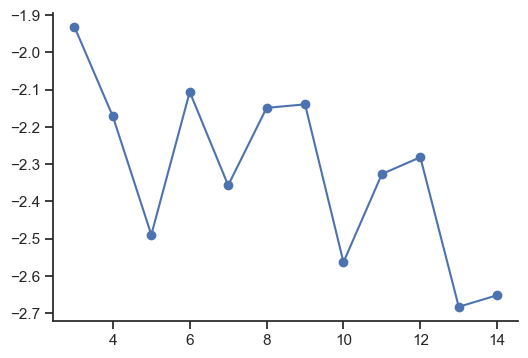

In [264]:
# Plot result
plt.figure(figsize=(6,4))
plt.plot(k_range, scores, marker='o')
plt.show()

In [265]:
# Find optimal number of topics (k) - c_v method
np.random.seed(42)
k_range = range(3,15)
scores = []

for k in k_range:
    lda_model2 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                  num_topics=k, passes=20,
                                  random_state=42)
    cm2 = CoherenceModel(model=lda_model2, corpus=corpus, 
                        dictionary=dictionary, texts=rev_data, coherence='c_v')
    print(cm2.get_coherence())
    scores.append(cm2.get_coherence())

0.356301358575124
0.38316440424107423
0.36370963529032585
0.36214406811188243
0.35859439342064364
0.38216749299050956
0.3862824948737888
0.3596623149677975
0.4007481726030292
0.3774764233316236
0.36702969899077975
0.3790164625152019


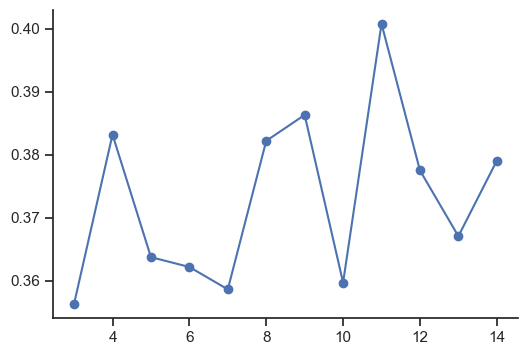

In [266]:
# Plot result
plt.figure(figsize=(6,4))
plt.plot(k_range, scores, marker='o')
plt.show()

**Note:** 
- 5, 6 and 7 topics have been tested based on above results (despite a high score with u_mass method, 3 topics may flatten too much)
- 6 topics has been chosen for final model for simplicity and interpretability

In [268]:
# Create final LDA model
num_topics=6
model = ldamodel.LdaModel(corpus, id2word=dictionary, 
                          num_topics=num_topics, passes=20,
                          iterations=500, random_state=42)

In [269]:
# View result
model.show_topics()

[(0,
  '0.032*"game" + 0.020*"fun" + 0.012*"play" + 0.011*"make" + 0.010*"one" + 0.010*"time" + 0.010*"great" + 0.009*"good" + 0.009*"love" + 0.009*"like"'),
 (1,
  '0.065*"game" + 0.016*"play" + 0.013*"great" + 0.012*"card" + 0.012*"expansion" + 0.011*"one" + 0.010*"fun" + 0.010*"player" + 0.009*"get" + 0.009*"new"'),
 (2,
  '0.032*"tile" + 0.019*"game" + 0.016*"set" + 0.011*"dungeon" + 0.011*"box" + 0.009*"adventure" + 0.008*"board" + 0.008*"would" + 0.008*"card" + 0.006*"like"'),
 (3,
  '0.018*"toy" + 0.015*"piece" + 0.014*"one" + 0.011*"ball" + 0.011*"magnet" + 0.010*"shape" + 0.008*"ball_whacks" + 0.008*"like" + 0.007*"together" + 0.006*"back"'),
 (4,
  '0.015*"book" + 0.015*"egg" + 0.012*"love" + 0.011*"great" + 0.008*"product" + 0.008*"would" + 0.007*"monster" + 0.007*"kid" + 0.006*"good" + 0.006*"one"'),
 (5,
  '0.016*"great" + 0.013*"love" + 0.013*"book" + 0.013*"sticker" + 0.011*"robot" + 0.011*"set" + 0.010*"puzzle" + 0.010*"tile" + 0.009*"year_old" + 0.009*"little"')]

In [270]:
# Save the LDA model
current_date = datetime.now().strftime("%Y%m%d")
model.save(f'lda_model_{num_topics}topics_{current_date}.model')

In [271]:
# Enable visualisation in this notebook
pyLDAvis.enable_notebook()
# Create filename
LDAvis_filepath = os.path.join('LDAviswithngrams2 ' + str(num_topics))
print(LDAvis_filepath)

LDAviswithngrams2 6


In [272]:
# Prepare file data
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
with open(LDAvis_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

In [273]:
# Save html of model
pyLDAvis.save_html(LDAvis_prepared, 'LDAviswithngrams2 ' + str(num_topics) + '.html')

In [317]:
# View final model in notebook
from IPython.display import display, HTML

html_file_path = 'Topic Modelling/FINAL_MODEL_LDAviswithngrams2 6_v2.html'
display(HTML(html_file_path))

### Observations on topic modelling model and topic clusters
##### **Overall Usefulness:**

- Topic coherence metrics do not show a clear ‘best’ number of clusters, suggesting that this model is not strong and could be refined.
- The model has largely broken reviews down by product category rather than e.g. emotional language, occasion, likes/dislikes etc. Thus, analysing reviews by category may be a simpler approach than topic modelling.
- However, using these findings may enhance targeted marketing.

##### **Topic Analysis**

**One:**  
- About monopoly-style games  
- Keywords: ‘Strategy’, ‘family’ – suggests marketing should target family occasions

**Two:**  
- About adventure games  
- Keywords: ‘Set’, ‘tile’, ‘ball’, ‘dungeon’, ‘whack’, ‘adventure’

**Three:**  
- Children’s puzzles and crafts  
- Keywords: ‘daughter’, ‘grandson’, ‘son’, ‘gift’ – bought by adults for kids, often as gifts - marketing should target gift-givers 
- Keywords: ‘adorable’, ‘cute’, ‘love’ – emotional connection is key

**Four:**  
- Adventure games, specifically Lords of Waterdeep  
- Keywords: ‘corruption’, ‘quest’ – themes tied to adventure games

**Five:**  
- Easter-specific products  
- Keywords: ‘tradition’, ‘true meaning’, ‘holy’ – strong emotional yearly connection
- Keywords: ‘grandchild’, ‘grandkids’ – suggests products are bought as gifts for grandchildren
- Opportunity to marketing to gift givers pre-Easter

**Six:**  
- Outlier, related to a specific book – can be ignored

# 